In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from collections import Counter, OrderedDict
from pandas.api.types import is_object_dtype, is_numeric_dtype
import statsmodels.api as sm
import plotly.express as px
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    LabelEncoder,
)
import sklearn
import warnings

warnings.filterwarnings("ignore")
import pickle
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    f1_score,
    fbeta_score,
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import eli5
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, SVMSMOTE, SMOTENC
from imblearn.pipeline import make_pipeline
from catboost import CatBoostClassifier


pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None
%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [8]:
app_train = pd.read_csv("application_train.csv")
bureau_df = pd.read_csv("bureau.csv")
bureau_bal = pd.read_csv("bureau_balance.csv")
credit_card_bal = pd.read_csv("credit_card_balance.csv")
previous_app = pd.read_csv("previous_application.csv")
pos_cash_bal = pd.read_csv("POS_CASH_balance.csv")
installments = pd.read_csv("installments_payments.csv")
app_test = pd.read_csv("application_test.csv")

## Functions

In [9]:
def missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame(
        {"total": df.isnull().sum(), "percentage": percent_missing}
    )
    missing_value_df.sort_values("percentage", ascending=False, inplace=True)
    return missing_value_df.head(20)

In [10]:
def plot_confusion_matrix(cm: np.ndarray, classes=None, title="Confusion matrix"):
    cm_norm = cm / cm.sum(axis=1).reshape(-1, 1)
    if classes is not None:
        sns.heatmap(
            cm_norm,
            xticklabels=classes,
            yticklabels=classes,
            vmin=0.0,
            vmax=1.0,
            annot=True,
            annot_kws={"size": 20},
        )
    else:
        sns.heatmap(cm_norm, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 3))
    # plot1: counts distribution of the variable

    if continuous:
        sns.histplot(
            app_train.loc[app_train[col_name].notnull(), col_name], kde=False, ax=ax1,
        )

    else:
        sns.countplot(
            x=col_name,
            data=app_train,
            order=sorted(app_train[col_name].unique()),
            color="#5975A4",
            saturation=1,
            ax=ax1,
        )

    ax1.set_xlabel(full_name)
    ax1.set_ylabel("Count")
    ax1.set_title(full_name)

    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(y=col_name, x="TARGET", data=app_train, ax=ax2)
        ax2.set_ylabel("")
        ax2.set_title(full_name + " by Loan Status")
        plt.xticks(rotation=90)
    else:
        Charged_Off_rates = app_train.groupby(col_name)["TARGET"].value_counts(
            normalize=True
        )[:, 1]
        sns.barplot(
            x=Charged_Off_rates.index,
            y=Charged_Off_rates.values,
            color="#5975A4",
            saturation=1,
            ax=ax2,
        )
        ax2.set_ylabel("Fraction of Loans with Difficulties")
        ax2.set_title("Difficulties Rate by " + full_name)
        ax2.set_xlabel(full_name)
        plt.xticks(rotation=90)
    # plot3: kde plot of the variable grouped by loan_status
    if continuous:
        facet = sns.FacetGrid(app_train, hue="TARGET", height=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        facet.add_legend()
        plt.xticks(rotation=90)
    else:
        fig = plt.figure(figsize=(12, 3))
        sns.countplot(
            x=col_name,
            hue="TARGET",
            data=app_train,
            order=sorted(app_train[col_name].unique()),
        )
        plt.xticks(rotation=90)

## Introduction

Startup Idea: To provide risk evaluation as a service for retail banks.


Responsibility: Responsible for everything product-related, from planning to data analysis to building the solution. We have quickly identified that machine learning will be an essential part of offering because models might be able to capture statistical patterns in the defaults on bank loans. 


Decision: To start investigation by downloading dataset from Home Credit Group. Define what is the most crucial problem for potential clients, proof-of-concept ideas. We will play with number of different models to have a robust and diversified offering with the potential clients.

Model Purpose: To predict whether client is at risk of not repaying loan at the application stage (classification task).

### Preliminary Plan

1) Get data from Home Credit Group
2) Explore data
    - Identify Target attribute
    - Analyse each feature and its characteristics of main data set
    - Study the correlations between attributes
    - Visualise the data
    - Study missing values and how to impute (if necessary)
3) Define metric
4) Perform a baseline modelling
5) Identify the promising transformations to apply
6) Try other models
7) Identify extra data that could improve results
8) Come up with most promising model
9) Deploy model

## Glimpse Of Data

In [11]:
print("Size of application_train data", app_train.shape)
print("Size of POS_CASH_balance data", pos_cash_bal.shape)
print("Size of bureau_balance data", bureau_bal.shape)
print("Size of previous_application data", previous_app.shape)
print("Size of installments_payments data", installments.shape)
print("Size of credit_card_balance data", credit_card_bal.shape)
print("Size of bureau data", bureau_df.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


In [12]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [13]:
app_train.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        351000.00   Unaccompanied          Working   
1       1129500.00          Family    State servant   
2        135000.00   Unaccompanied          Working   
3        297000.00   Unaccompanied          Working   
4        513000.00   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers             1.00   
1                 1           1           0      Core staff             2.00   
2                 1           1           0        Laborers             1.00   
3                 1           0           0        Laborers             2.00   
4                 1           0           0      Core staff             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [14]:
pos_cash_bal.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31           48.00   
1     1715348      367990             -33           36.00   
2     1784872      397406             -32           12.00   
3     1903291      269225             -35           48.00   
4     2341044      334279             -35           36.00   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                  45.00               Active       0           0  
1                  35.00               Active       0           0  
2                   9.00               Active       0           0  
3                  42.00               Active       0           0  
4                  35.00               Active       0           0

In [15]:
bureau_bal.head(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [16]:
previous_app.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans      1730.43         17145.00   
1     2802425      108129         Cash loans     25188.62        607500.00   
2     2523466      122040         Cash loans     15060.74        112500.00   
3     2819243      176158         Cash loans     47041.33        450000.00   
4     1784265      202054         Cash loans     31924.40        337500.00   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0    17145.00              0.00         17145.00                   SATURDAY   
1   679671.00               NaN        607500.00                   THURSDAY   
2   136444.50               NaN        112500.00                    TUESDAY   
3   470790.00               NaN        450000.00                     MONDAY   
4   404055.00               NaN        337500.00                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1               0.00                   0.18   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                      0.87                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0        12.00           middle  POS mobile with interest           365243.00   
1        36.00       low_action          Cash X-Sell: low           365243.00   
2        12.00             high         Cash X-Sell: high           365243.00   
3        12.00           middle       Cash X-Sell: middle           365243.00   
4        24.00             high         Cash Street: high                 NaN   

   D

In [17]:
installments.head(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                    1.00                      6   
1     1330831      151639                    0.00                     34   
2     2085231      193053                    2.00                      1   
3     2452527      199697                    1.00                      3   
4     2714724      167756                    1.00                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0         -1180.00            -1187.00         6948.36      6948.36  
1         -2156.00            -2156.00         1716.53      1716.53  
2           -63.00              -63.00        25425.00     25425.00  
3         -2418.00            -2426.00        24350.13     24350.13  
4         -1383.00            -1366.00         2165.04      2160.59

In [18]:
credit_card_bal.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6        56.97   
1     2582071      363914              -1     63975.56   
2     1740877      371185              -7     31815.22   
3     1389973      337855              -4    236572.11   
4     1891521      126868              -1    453919.46   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                      0.00                877.50   
1                    45000                   2250.00               2250.00   
2                   450000                      0.00                  0.00   
3                   225000                   2250.00               2250.00   
4                   450000                      0.00              11547.00   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                        0.00                    877.50   
1                        0.00                      0.00   
2                        0.00                      0.00   
3                        0.00                      0.00   
4                        0.00                  11547.00   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                  1700.33              1800.00                    1800.00   
1                  2250.00              2250.00                    2250.00   
2                  2250.00              2250.00                    2250.00   
3                 11795.76             11925.00                   11925.00   
4                 22924.89             27000.00                   27000.00   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                      0.00           0.00                  0.00   
1                  60175.08       64875.56              64875.56   
2                  26926.42       31460.08              31460.08   
3                 224949.29      233048.97             233048.97   
4                 443044.40      453919.46             453919.46   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                      0.00                     1                        0.00   
1                      1.00                     1                        0.00   
2                      0.00                     0                        0.00   
3                      1.00                     1                        0.00   
4                      0.00                     1                        0.00   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                      1.00                      35.00               Active   
1                      0.00                      69.00               Active   
2                      0.00                      30.00               Active   
3                      0.00                      10.00               Active   
4                      1.00                     101.00               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [19]:
bureau_df.head(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0              -153.00            -153.00   
1                   0              1075.00                NaN   
2                   0               528.00                NaN   
3                   0                  NaN                NaN   
4                   0              1197.00                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        91323.00   
1                     NaN                   0       225000.00   
2                     NaN                   0       464323.50   
3                     NaN                   0        90000.00   
4                77674.50                   0      2700000.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                 0.00                   NaN                    0.00   
1            171342.00                   NaN                    0.00   
2                  NaN                   NaN                    0.00   
3                  NaN                   NaN                    0.00   
4                  NaN                   NaN                    0.00   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

### Missing Data

Next we can look at the number and percentage of missing values in each data set.

In [20]:
missing_values(app_train)

total  percentage
COMMONAREA_MEDI           214865       69.87
COMMONAREA_AVG            214865       69.87
COMMONAREA_MODE           214865       69.87
NONLIVINGAPARTMENTS_MODE  213514       69.43
NONLIVINGAPARTMENTS_AVG   213514       69.43
NONLIVINGAPARTMENTS_MEDI  213514       69.43
FONDKAPREMONT_MODE        210295       68.39
LIVINGAPARTMENTS_MODE     210199       68.35
LIVINGAPARTMENTS_AVG      210199       68.35
LIVINGAPARTMENTS_MEDI     210199       68.35
FLOORSMIN_AVG             208642       67.85
FLOORSMIN_MODE            208642       67.85
FLOORSMIN_MEDI            208642       67.85
YEARS_BUILD_MEDI          204488       66.50
YEARS_BUILD_MODE          204488       66.50
YEARS_BUILD_AVG           204488       66.50
OWN_CAR_AGE               202929       65.99
LANDAREA_MEDI             182590       59.38
LANDAREA_MODE             182590       59.38
LANDAREA_AVG              182590       59.38

In [21]:
missing_values(bureau_bal)

total  percentage
SK_ID_BUREAU        0        0.00
MONTHS_BALANCE      0        0.00
STATUS              0        0.00

In [22]:
missing_values(previous_app)

total  percentage
RATE_INTEREST_PRIVILEGED   1664263       99.64
RATE_INTEREST_PRIMARY      1664263       99.64
AMT_DOWN_PAYMENT            895844       53.64
RATE_DOWN_PAYMENT           895844       53.64
NAME_TYPE_SUITE             820405       49.12
NFLAG_INSURED_ON_APPROVAL   673065       40.30
DAYS_TERMINATION            673065       40.30
DAYS_LAST_DUE               673065       40.30
DAYS_LAST_DUE_1ST_VERSION   673065       40.30
DAYS_FIRST_DUE              673065       40.30
DAYS_FIRST_DRAWING          673065       40.30
AMT_GOODS_PRICE             385515       23.08
AMT_ANNUITY                 372235       22.29
CNT_PAYMENT                 372230       22.29
PRODUCT_COMBINATION            346        0.02
AMT_CREDIT                       1        0.00
NAME_YIELD_GROUP                 0        0.00
NAME_PORTFOLIO                   0        0.00
NAME_SELLER_INDUSTRY             0        0.00
SELLERPLACE_AREA                 0        0.00

In [23]:
missing_values(installments)

total  percentage
DAYS_ENTRY_PAYMENT       2905        0.02
AMT_PAYMENT              2905        0.02
SK_ID_PREV                  0        0.00
SK_ID_CURR                  0        0.00
NUM_INSTALMENT_VERSION      0        0.00
NUM_INSTALMENT_NUMBER       0        0.00
DAYS_INSTALMENT             0        0.00
AMT_INSTALMENT              0        0.00

In [24]:
missing_values(credit_card_bal)

total  percentage
AMT_PAYMENT_CURRENT         767988       20.00
AMT_DRAWINGS_ATM_CURRENT    749816       19.52
CNT_DRAWINGS_POS_CURRENT    749816       19.52
AMT_DRAWINGS_OTHER_CURRENT  749816       19.52
AMT_DRAWINGS_POS_CURRENT    749816       19.52
CNT_DRAWINGS_OTHER_CURRENT  749816       19.52
CNT_DRAWINGS_ATM_CURRENT    749816       19.52
CNT_INSTALMENT_MATURE_CUM   305236        7.95
AMT_INST_MIN_REGULARITY     305236        7.95
SK_ID_PREV                       0        0.00
AMT_TOTAL_RECEIVABLE             0        0.00
SK_DPD                           0        0.00
NAME_CONTRACT_STATUS             0        0.00
CNT_DRAWINGS_CURRENT             0        0.00
AMT_PAYMENT_TOTAL_CURRENT        0        0.00
AMT_RECIVABLE                    0        0.00
AMT_RECEIVABLE_PRINCIPAL         0        0.00
SK_ID_CURR                       0        0.00
AMT_DRAWINGS_CURRENT             0        0.00
AMT_CREDIT_LIMIT_ACTUAL          0        0.00

In [25]:
missing_values(bureau_df)

total  percentage
AMT_ANNUITY             1226791       71.47
AMT_CREDIT_MAX_OVERDUE  1124488       65.51
DAYS_ENDDATE_FACT        633653       36.92
AMT_CREDIT_SUM_LIMIT     591780       34.48
AMT_CREDIT_SUM_DEBT      257669       15.01
DAYS_CREDIT_ENDDATE      105553        6.15
AMT_CREDIT_SUM               13        0.00
CREDIT_ACTIVE                 0        0.00
CREDIT_CURRENCY               0        0.00
DAYS_CREDIT                   0        0.00
CREDIT_DAY_OVERDUE            0        0.00
SK_ID_BUREAU                  0        0.00
CNT_CREDIT_PROLONG            0        0.00
AMT_CREDIT_SUM_OVERDUE        0        0.00
CREDIT_TYPE                   0        0.00
DAYS_CREDIT_UPDATE            0        0.00
SK_ID_CURR                    0        0.00

When it comes time to build our machine learning models, we will have to fill in these missing values. In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

### Target Variable

In [26]:
app_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

We have a very imbalanced data here, with 90% of those who have repaid the loan, and 10% of those who had difficulties. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in data to reflect this problem.

### Feature Analysis (application_train)

In this section we are going to analyse features of our main data set (application_train) one by one.

Everything we change in app_train we also change in app_test.

##### NAME_CONTRACT_TYPE - identification if loan is cash or revolving

In [27]:
app_train["NAME_CONTRACT_TYPE"].describe()

count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object

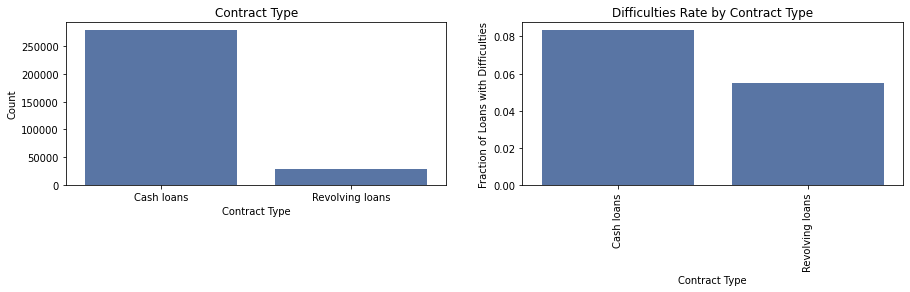

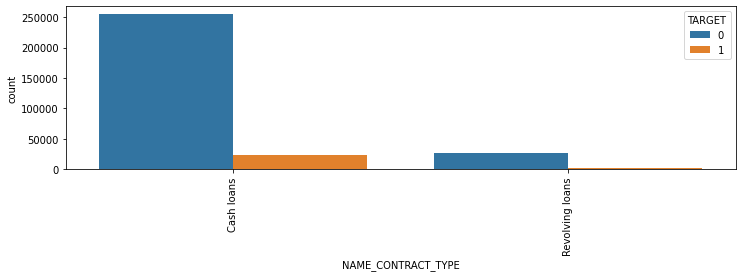

In [28]:
plot_var("NAME_CONTRACT_TYPE", "Contract Type", continuous=False)

There is low number of examples for Revolving Loans, however it seems like Cash Loans has a little higher Difficulties rate.

##### CODE_GENDER - gender of client

In [29]:
app_train["CODE_GENDER"].describe()

count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object

In [30]:
app_train["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

We have 4 examples of different gender than Female or Male, thus it is safer to be removed for our analysis.

In [31]:
app_train = app_train[app_train["CODE_GENDER"] != "XNA"]
app_test = app_test[app_test["CODE_GENDER"] != "XNA"]

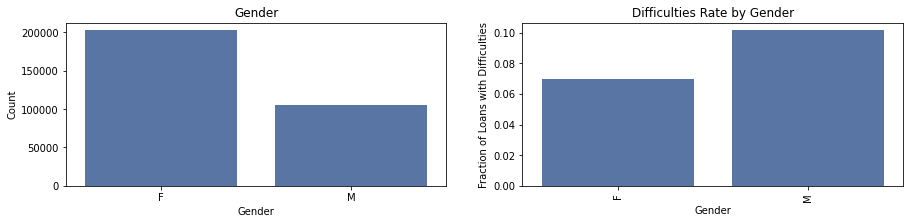

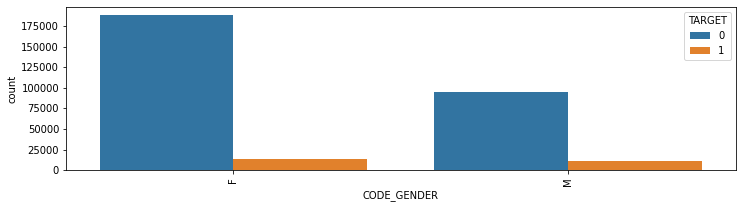

In [32]:
plot_var("CODE_GENDER", "Gender", continuous=False)

Male seems to have a higher Difficulty rate, when dealing with loans

##### FLAG_OWN_CAR - flag if the client owns a car

In [33]:
app_train["FLAG_OWN_CAR"].describe()

count     307507
unique         2
top            N
freq      202922
Name: FLAG_OWN_CAR, dtype: object

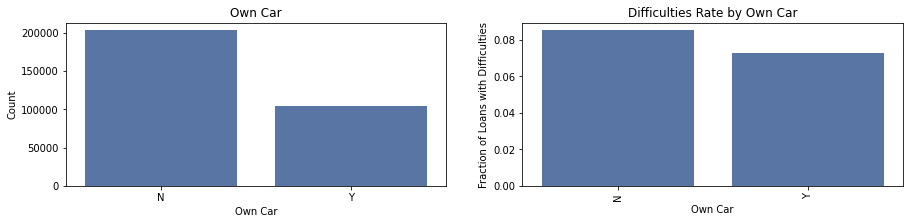

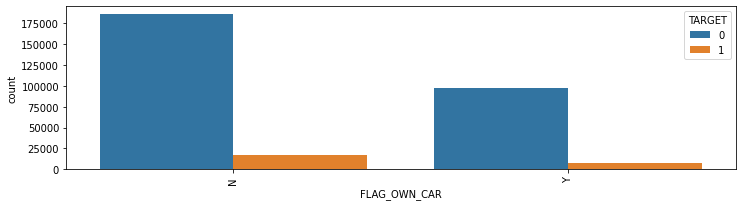

In [34]:
plot_var("FLAG_OWN_CAR", "Own Car", continuous=False)

No significant difference here.

##### FLAG_OWN_REALTY - flag if the client owns a house or flat

In [35]:
app_train["FLAG_OWN_REALTY"].describe()

count     307507
unique         2
top            Y
freq      213308
Name: FLAG_OWN_REALTY, dtype: object

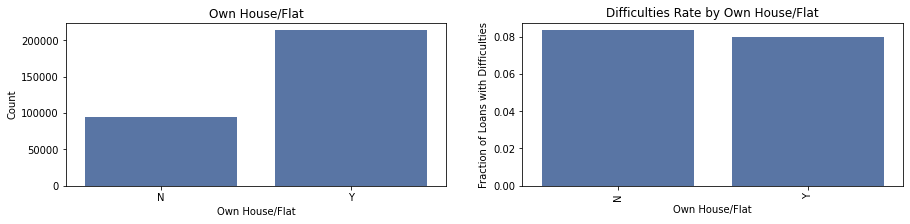

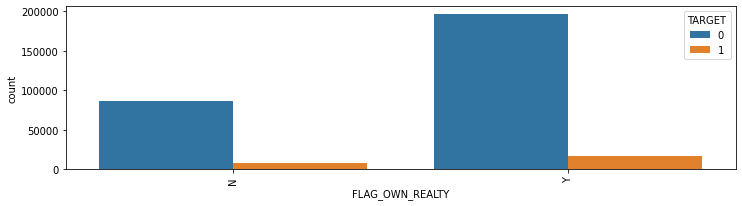

In [36]:
plot_var("FLAG_OWN_REALTY", "Own House/Flat", continuous=False)

Interestingly enough, there is no significant difference.

##### CNT_CHILDREN - Number of children the client has

In [37]:
app_train["CNT_CHILDREN"].describe()

count   307507.00
mean         0.42
std          0.72
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         19.00
Name: CNT_CHILDREN, dtype: float64

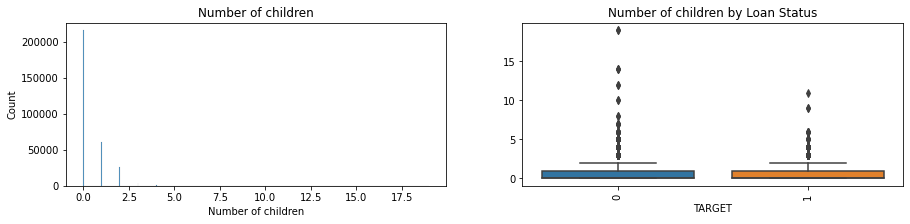

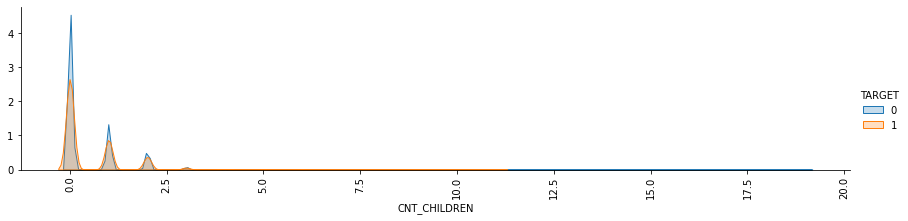

In [38]:
plot_var("CNT_CHILDREN", "Number of children", continuous=True)

Most of the clients has either no children, or between 1 and 2. There is however no strong difference in loan repayment between the number of children

##### AMT_INCOME_TOTAL - Income of the client

In [39]:
app_train["AMT_INCOME_TOTAL"].describe()

count      307507.00
mean       168797.69
std        237124.63
min         25650.00
25%        112500.00
50%        147150.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Income ranges from 25k to 117M, very high variation, this might need to be dealt before modelling, but for now, we log-transform the values. Do the same for app_test.

In [40]:
app_train["AMT_INCOME_TOTAL"] = app_train["AMT_INCOME_TOTAL"].apply(
    lambda x: np.log10(x + 1)
)
app_test["AMT_INCOME_TOTAL"] = app_test["AMT_INCOME_TOTAL"].apply(
    lambda x: np.log10(x + 1)
)

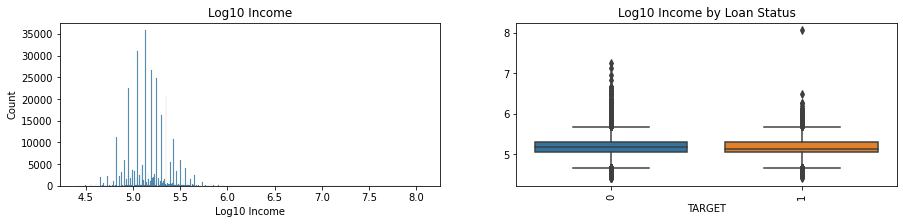

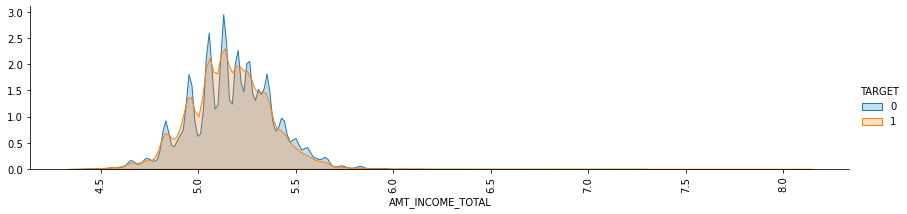

In [41]:
plot_var("AMT_INCOME_TOTAL", "Log10 Income", continuous=True)

Now when we have normalised data, we can see that those who have difficulties in repaying loan has a slightly lower mean income

##### AMT_CREDIT - Credit amount of the loan

In [42]:
app_train["AMT_CREDIT"].describe()

count    307507.00
mean     599028.60
std      402492.60
min       45000.00
25%      270000.00
50%      513531.00
75%      808650.00
max     4050000.00
Name: AMT_CREDIT, dtype: float64

Credit amount ranges from 45k to 4M. Range looks fare, lets see our plots.

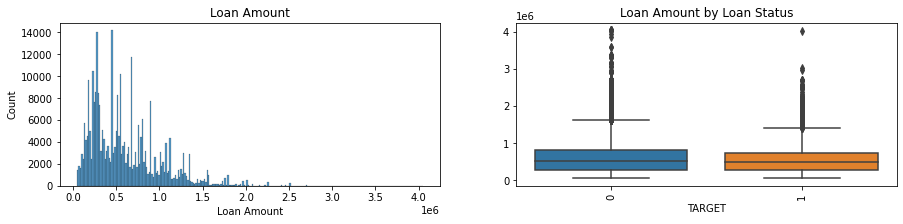

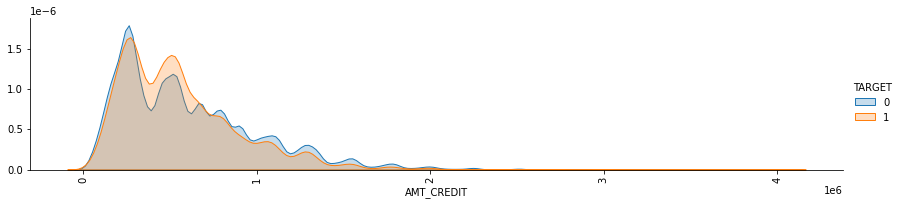

In [43]:
plot_var("AMT_CREDIT", "Loan Amount", continuous=True)

No obvious relationship here.

##### AMT_ANNUITY - Loan annuity

In [44]:
app_train["AMT_ANNUITY"].describe()

count   307495.00
mean     27108.67
std      14493.80
min       1615.50
25%      16524.00
50%      24903.00
75%      34596.00
max     258025.50
Name: AMT_ANNUITY, dtype: float64

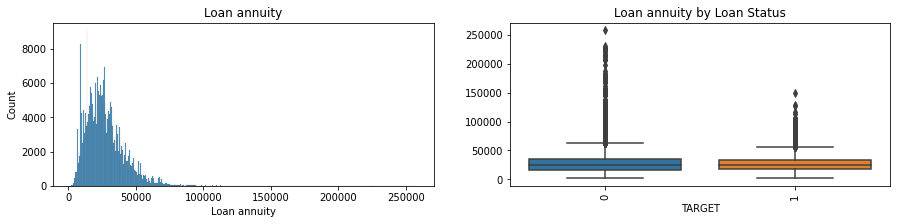

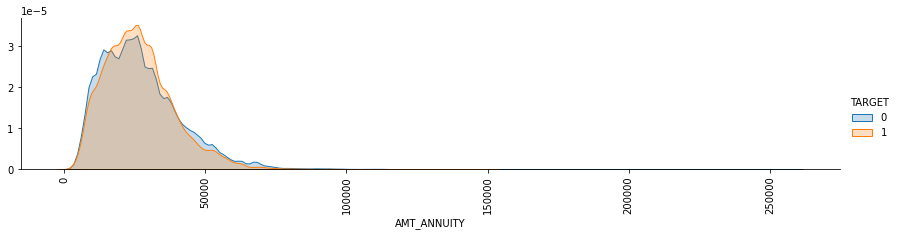

In [45]:
plot_var("AMT_ANNUITY", "Loan annuity", continuous=True)

##### AMT_GOODS_PRICE - For consumer loans it is the price of the goods for which the loan is given

In [46]:
app_train["AMT_GOODS_PRICE"].describe()

count    307229.00
mean     538397.72
std      369447.25
min       40500.00
25%      238500.00
50%      450000.00
75%      679500.00
max     4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

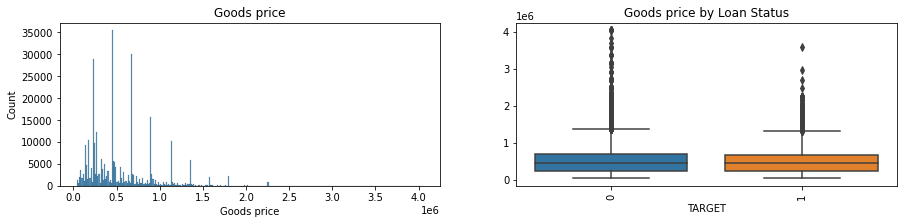

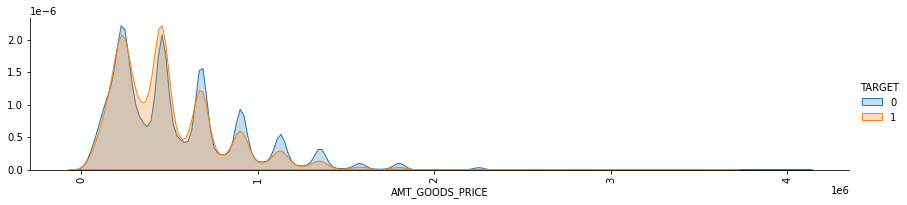

In [47]:
plot_var("AMT_GOODS_PRICE", "Goods price", continuous=True)

##### NAME_TYPE_SUITE - Who was accompanying client when he was applying for the loan

In [48]:
app_train["NAME_TYPE_SUITE"].describe()

count            306215
unique                7
top       Unaccompanied
freq             248523
Name: NAME_TYPE_SUITE, dtype: object

In [49]:
app_train["NAME_TYPE_SUITE"].fillna("Unaccompanied", inplace=True)
app_train["NAME_TYPE_SUITE"].fillna("Unaccompanied", inplace=True)

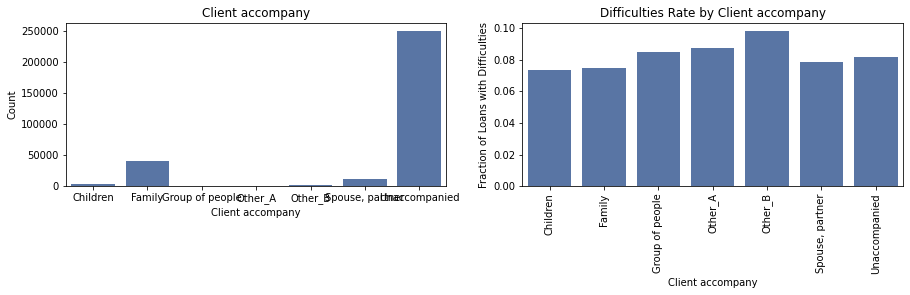

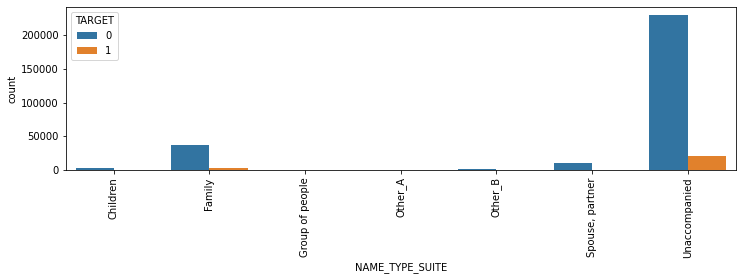

In [50]:
plot_var("NAME_TYPE_SUITE", "Client accompany", continuous=False)

Most group with Difficulties are with prefix Other_

##### NAME_INCOME_TYPE - Clients income type (businessman, working, maternity leave,…)

In [51]:
app_train["NAME_INCOME_TYPE"].describe()

count      307507
unique          8
top       Working
freq       158771
Name: NAME_INCOME_TYPE, dtype: object

In [52]:
app_train["NAME_INCOME_TYPE"].value_counts()

Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

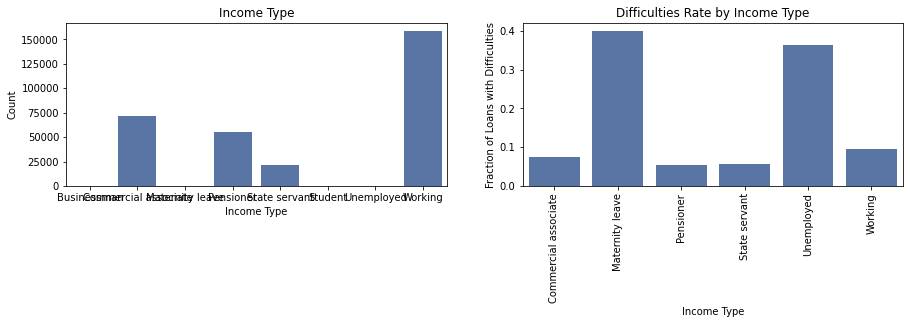

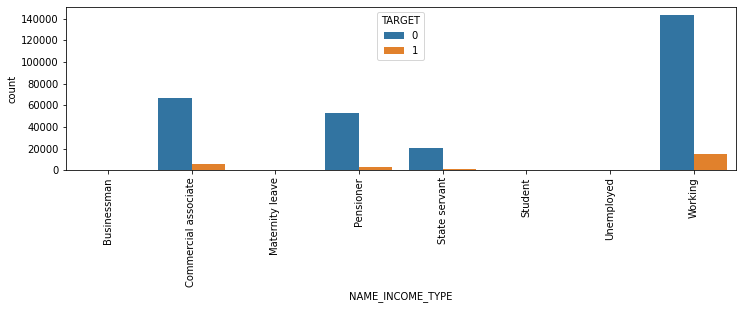

In [53]:
plot_var("NAME_INCOME_TYPE", "Income Type", continuous=False)

Half of the categories has very low number of samples, thus this feature is not very reliable

##### NAME_EDUCATION_TYPE- Level of highest education the client achieved

In [54]:
app_train["NAME_EDUCATION_TYPE"].describe()

count                            307507
unique                                5
top       Secondary / secondary special
freq                             218389
Name: NAME_EDUCATION_TYPE, dtype: object

In [55]:
app_train["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    218389
Higher education                  74862
Incomplete higher                 10276
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

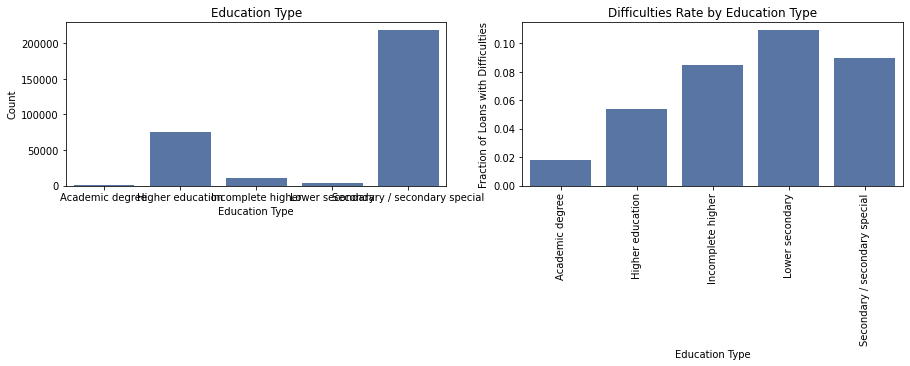

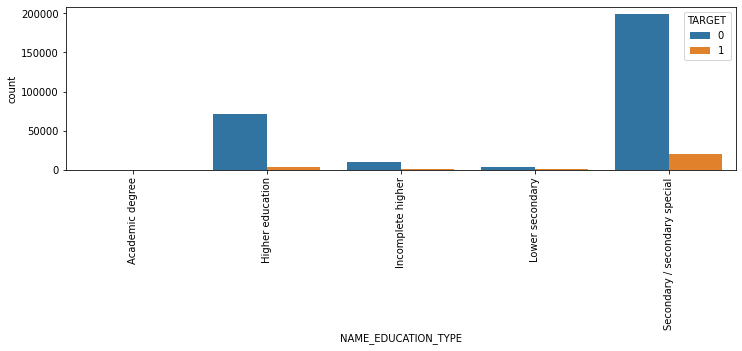

In [56]:
plot_var("NAME_EDUCATION_TYPE", "Education Type", continuous=False)

Again, one category dominates feature, looks like Lower Secondary group has highes Difficulty rate

##### NAME_FAMILY_STATUS - Family status of the client

In [57]:
app_train["NAME_FAMILY_STATUS"].describe()

count      307507
unique          6
top       Married
freq       196429
Name: NAME_FAMILY_STATUS, dtype: object

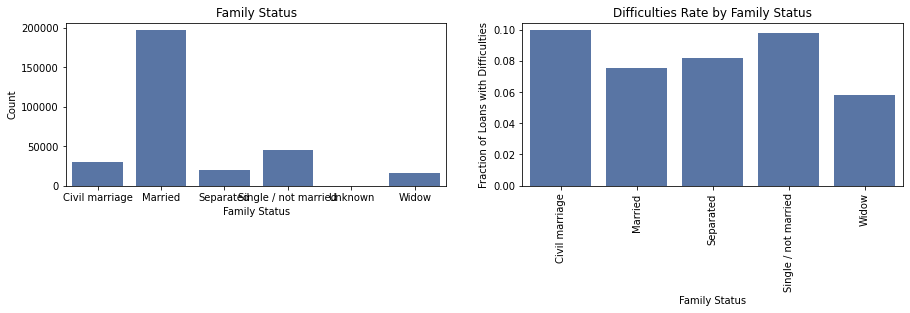

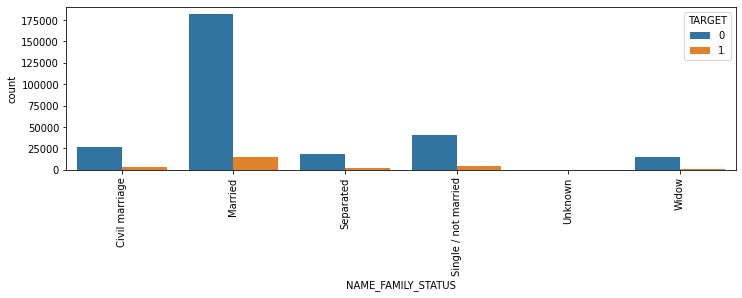

In [58]:
plot_var("NAME_FAMILY_STATUS", "Family Status", continuous=False)

Most of the loans are taken from Married clients, no high difference in Difficulties rate but Civil Marriage and Single groups has a little higher rate

##### NAME_HOUSING_TYPE - What is the housing situation of the client (renting, living with parents, ...)

In [59]:
app_train["NAME_HOUSING_TYPE"].describe()

count                307507
unique                    6
top       House / apartment
freq                 272865
Name: NAME_HOUSING_TYPE, dtype: object

In [60]:
app_train["NAME_HOUSING_TYPE"].value_counts()

House / apartment      272865
With parents            14840
Municipal apartment     11182
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

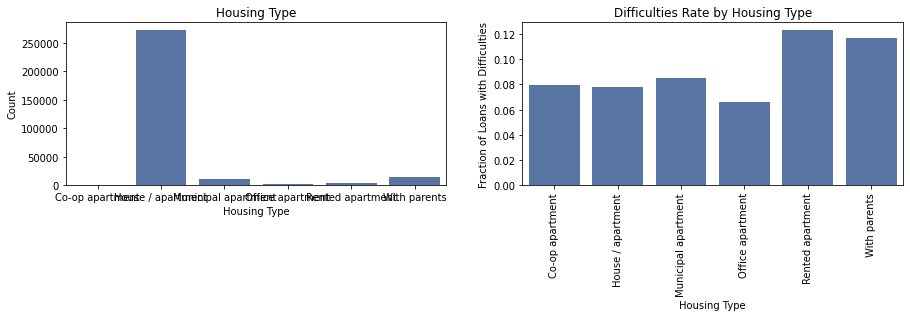

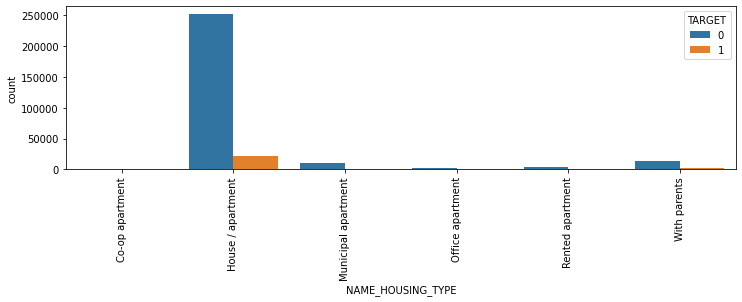

In [61]:
plot_var("NAME_HOUSING_TYPE", "Housing Type", continuous=False)

As expected, those who are Renting has a highest Difficulty rating(riskiest group)

##### REGION_POPULATION_RELATIVE - Normalized population of region where client lives

In [62]:
app_train["REGION_POPULATION_RELATIVE"].describe()

count   307507.00
mean         0.02
std          0.01
min          0.00
25%          0.01
50%          0.02
75%          0.03
max          0.07
Name: REGION_POPULATION_RELATIVE, dtype: float64

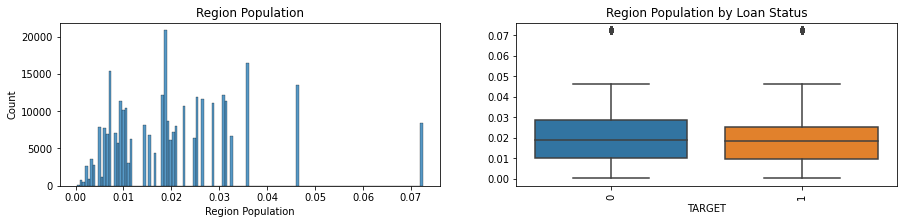

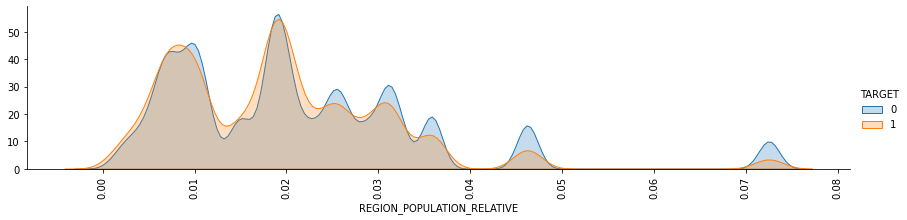

In [63]:
plot_var("REGION_POPULATION_RELATIVE", "Region Population", continuous=True)

Looks like in highly populated region loans have higher stability to be repaid.

##### DAYS_BIRTH - Client's age in days at the time of application,time only relative to the application

In [64]:
app_train["DAYS_BIRTH"].describe()

count   307507.00
mean    -16037.03
std       4363.98
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Lets convert this to real ages, for comfort analysis in future

In [65]:
app_train["DAYS_BIRTH"] = app_train["DAYS_BIRTH"] / (-360)

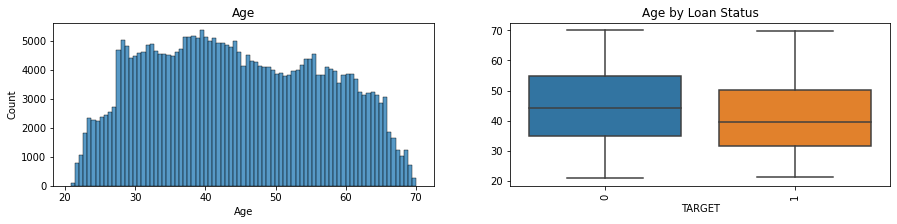

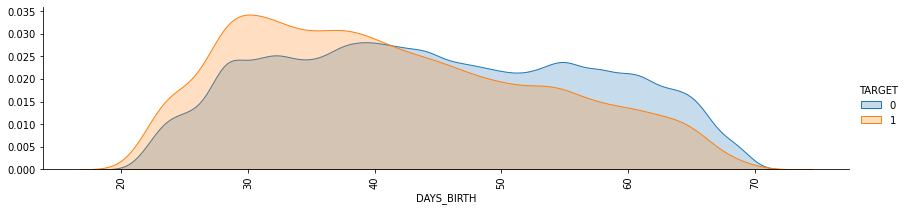

In [66]:
plot_var("DAYS_BIRTH", "Age", continuous=True)

We have different age groups in the dataset, obviously younger clients seems to have difficulties in repaying loan more often.

##### DAYS_EMPLOYED - How many days before the application the person started current employment,time only relative to the application

In [67]:
app_train["DAYS_EMPLOYED"].describe()

count   307507.00
mean     63815.93
std     141276.47
min     -17912.00
25%      -2760.00
50%      -1213.00
75%       -289.00
max     365243.00
Name: DAYS_EMPLOYED, dtype: float64

Numbers does not make sense for this feature, some negative some positive, mean value is 63k days which is ~175 years of employment.

In [68]:
len(app_train[app_train["DAYS_EMPLOYED"] > 300000])

55374

Nearly 1/6 of data has outlier values per my opinion, lets put those to median values, and make all values positive

In [69]:
app_train.loc[app_train["DAYS_EMPLOYED"] > 300000, "DAYS_EMPLOYED"] = app_train[
    "DAYS_EMPLOYED"
].median()
app_test.loc[app_test["DAYS_EMPLOYED"] > 300000, "DAYS_EMPLOYED"] = app_test[
    "DAYS_EMPLOYED"
].median()

In [70]:
app_train["DAYS_EMPLOYED"] *= -1
app_test["DAYS_EMPLOYED"] *= -1

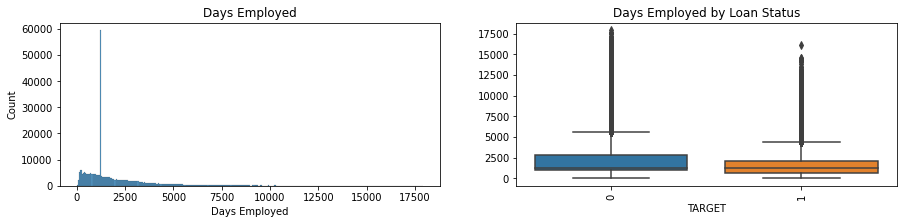

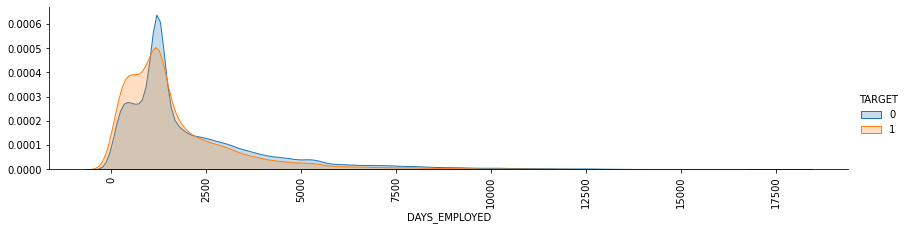

In [71]:
plot_var("DAYS_EMPLOYED", "Days Employed", continuous=True)

Most of the people are employed from 0 to 3 years. No strong impact on target though.

##### DAYS_REGISTRATION - How many days before the application did client change his registration,time only relative to the application

In [72]:
app_train["DAYS_REGISTRATION"].describe()

count   307507.00
mean     -4986.13
std       3522.88
min     -24672.00
25%      -7479.50
50%      -4504.00
75%      -2010.00
max          0.00
Name: DAYS_REGISTRATION, dtype: float64

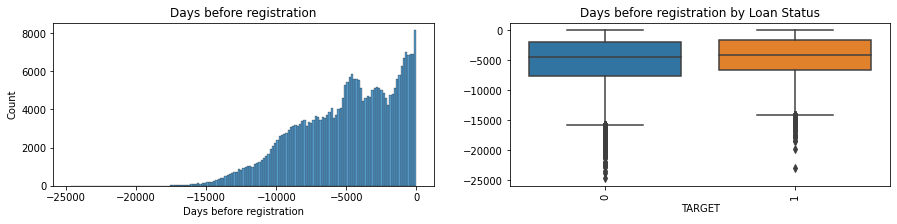

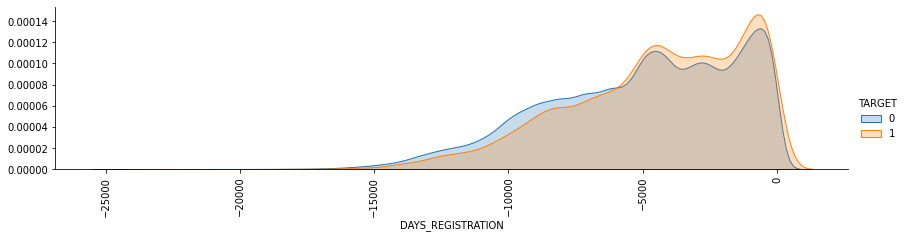

In [73]:
plot_var("DAYS_REGISTRATION", "Days before registration", continuous=True)

##### DAYS_ID_PUBLISH - How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application

In [74]:
app_train["DAYS_ID_PUBLISH"].describe()

count   307507.00
mean     -2994.20
std       1509.45
min      -7197.00
25%      -4299.00
50%      -3254.00
75%      -1720.00
max          0.00
Name: DAYS_ID_PUBLISH, dtype: float64

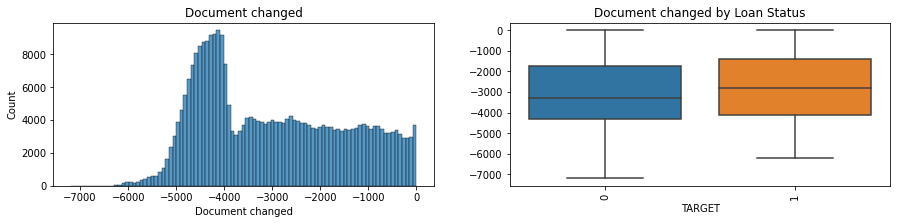

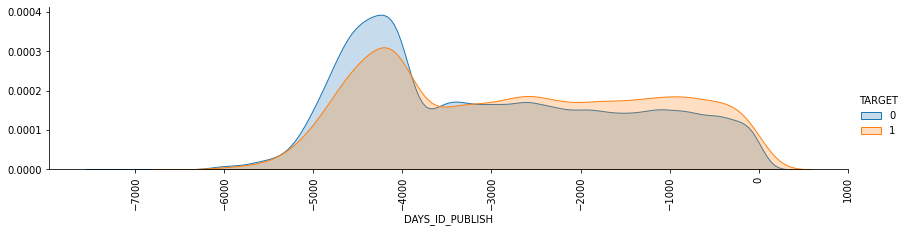

In [75]:
plot_var("DAYS_ID_PUBLISH", "Document changed", continuous=True)

From boxplot, it seems like difficulties occur more often for those with more recent document change, might not be the pattern. 

##### OWN_CAR_AGE - Age of client's car

In [76]:
app_train["OWN_CAR_AGE"].describe()

count   104580.00
mean        12.06
std         11.94
min          0.00
25%          5.00
50%          9.00
75%         15.00
max         91.00
Name: OWN_CAR_AGE, dtype: float64

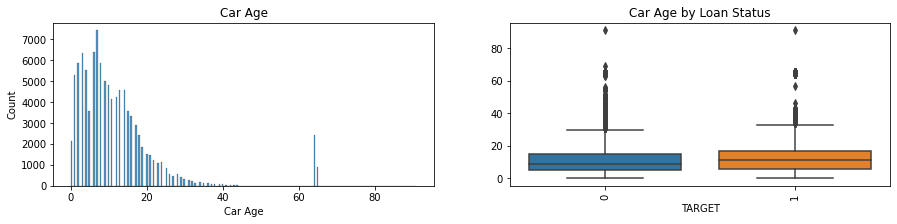

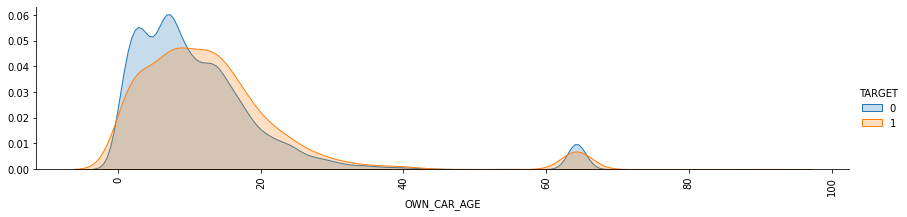

In [77]:
plot_var("OWN_CAR_AGE", "Car Age", continuous=True)

As expected, clients with older cars, happen to have difficulties more often, but not significantly

##### FLAG_MOBIL - Did client provide mobile phone (1=YES, 0=NO)

In [78]:
app_train["FLAG_MOBIL"].value_counts()

1    307506
0         1
Name: FLAG_MOBIL, dtype: int64

Only 1 person has not provided their mobile phone, lets remove this feature.

In [79]:
app_train.drop("FLAG_MOBIL", axis=1, inplace=True)
app_test.drop("FLAG_MOBIL", axis=1, inplace=True)

##### FLAG_EMP_PHONE - Did client provide work phone (1=YES, 0=NO)

In [80]:
app_train["FLAG_EMP_PHONE"].value_counts()

1    252121
0     55386
Name: FLAG_EMP_PHONE, dtype: int64

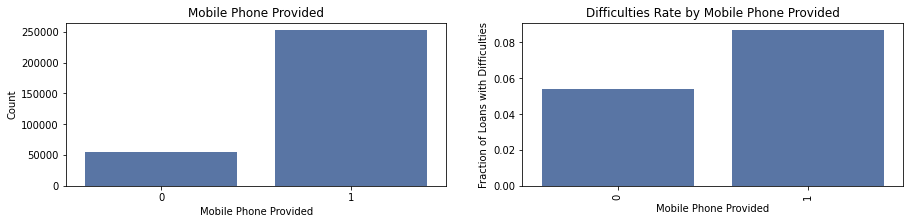

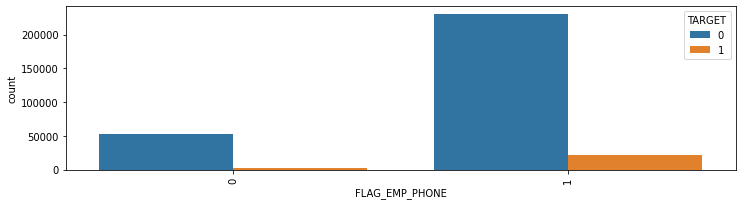

In [81]:
plot_var("FLAG_EMP_PHONE", "Mobile Phone Provided", continuous=False)

Those who provides work phone face difficulties more often. My assumption is, that those who does not provide work phones, has a lot of calls and might be taking higher/more successful positions.

##### FLAG_CONT_MOBILE - Was mobile phone reachable (1=YES, 0=NO)

In [82]:
app_train["FLAG_CONT_MOBILE"].value_counts()

1    306933
0       574
Name: FLAG_CONT_MOBILE, dtype: int64

Remove feature due to being too imbalanced

In [83]:
app_train.drop("FLAG_CONT_MOBILE", axis=1, inplace=True)
app_test.drop("FLAG_CONT_MOBILE", axis=1, inplace=True)

##### FLAG_PHONE - Did client provide home phone (1=YES, 0=NO)

In [84]:
app_train["FLAG_PHONE"].value_counts()

0    221080
1     86427
Name: FLAG_PHONE, dtype: int64

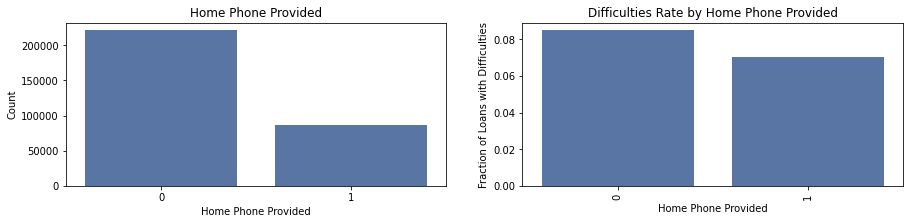

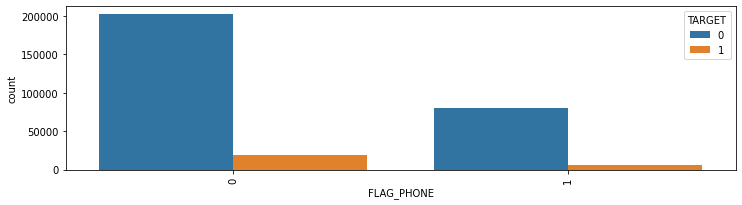

In [85]:
plot_var("FLAG_PHONE", "Home Phone Provided", continuous=False)

##### FLAG_EMAIL - Did client provide email (1=YES, 0=NO)

In [86]:
app_train["FLAG_EMAIL"].value_counts()

0    290065
1     17442
Name: FLAG_EMAIL, dtype: int64

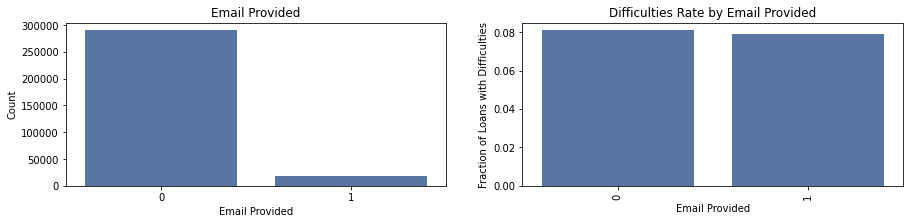

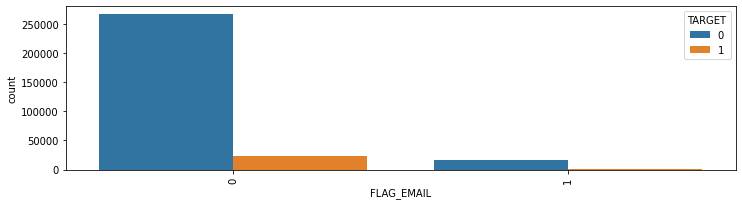

In [87]:
plot_var("FLAG_EMAIL", "Email Provided", continuous=False)

##### OCCUPATION_TYPE - What kind of occupation does the client have

In [88]:
app_train["OCCUPATION_TYPE"].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [89]:
app_train["OCCUPATION_TYPE"].isnull().sum()

96389

Third of values are missing, it is tough to decide how to impute this kind of feature, as some of those could be without occupation, and imputing with median may introduce bias. Lets look at this later during modeling.

##### CNT_FAM_MEMBERS - How many family members does client have

In [90]:
app_train["CNT_FAM_MEMBERS"].describe()

count   307505.00
mean         2.15
std          0.91
min          1.00
25%          2.00
50%          2.00
75%          3.00
max         20.00
Name: CNT_FAM_MEMBERS, dtype: float64

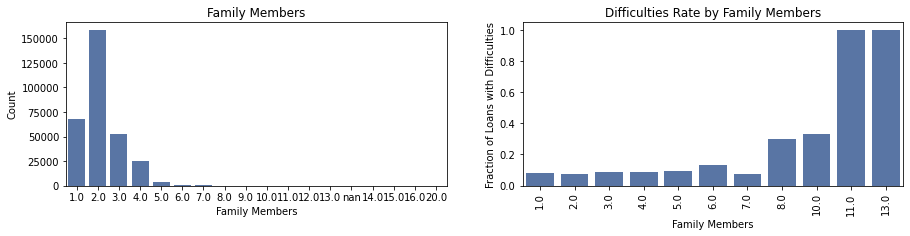

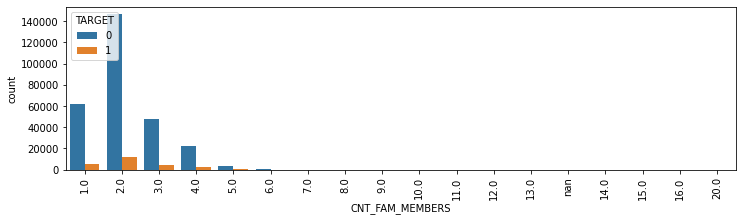

In [91]:
plot_var("CNT_FAM_MEMBERS", "Family Members", continuous=False)

When family member count exceeds 7, the risk of having problems with loan drastically increases

##### REGION_RATING_CLIENT - Our rating of the region where client lives (1,2,3)

In [92]:
app_train["REGION_RATING_CLIENT"].value_counts()

2    226981
3     48329
1     32197
Name: REGION_RATING_CLIENT, dtype: int64

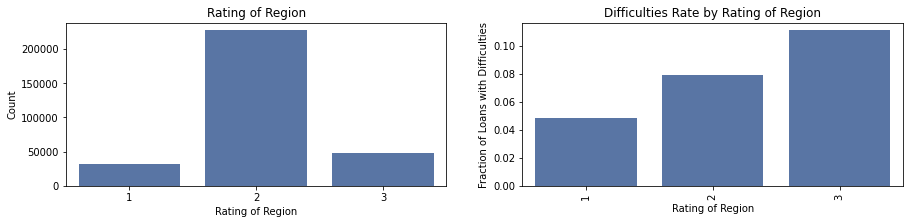

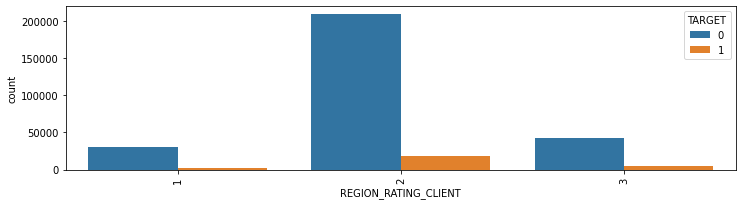

In [93]:
plot_var("REGION_RATING_CLIENT", "Rating of Region", continuous=False)

Its local rating of the HomeCredit office, seems like its goes from rating goes from 1 to 3 (1 being best), and highly effects loan status

##### REGION_RATING_CLIENT_W_CITY - Our rating of the region where client lives with taking city into account (1,2,3)

In [94]:
app_train["REGION_RATING_CLIENT_W_CITY"].value_counts()

2    229481
3     43859
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

Lets see if this feature correlates with previous one

In [95]:
app_train[["REGION_RATING_CLIENT_W_CITY", "REGION_RATING_CLIENT"]].corr()

REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY                         1.00                  0.95
REGION_RATING_CLIENT                                0.95                  1.00

Two features has ideal correlation, so lets drop the latter one.

In [96]:
app_train.drop("REGION_RATING_CLIENT_W_CITY", axis=1, inplace=True)
app_test.drop("REGION_RATING_CLIENT_W_CITY", axis=1, inplace=True)

##### WEEKDAY_APPR_PROCESS_START - On which day of the week did the client apply for the loan

In [97]:
app_train["WEEKDAY_APPR_PROCESS_START"].describe()

count      307507
unique          7
top       TUESDAY
freq        53900
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

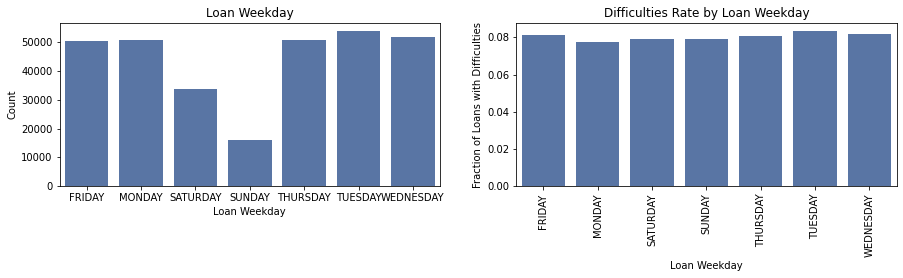

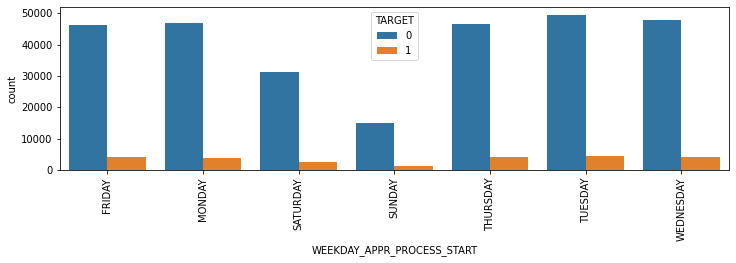

In [98]:
plot_var("WEEKDAY_APPR_PROCESS_START", "Loan Weekday", continuous=False)

No pattern for this feature

##### HOUR_APPR_PROCESS_START - Approximately at what hour did the client apply for the loan,rounded

In [99]:
app_train["HOUR_APPR_PROCESS_START"].describe()

count   307507.00
mean        12.06
std          3.27
min          0.00
25%         10.00
50%         12.00
75%         14.00
max         23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

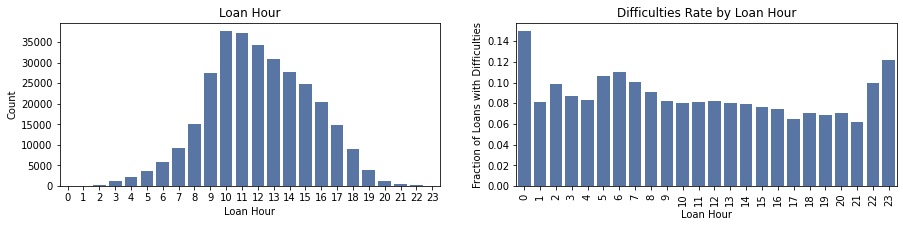

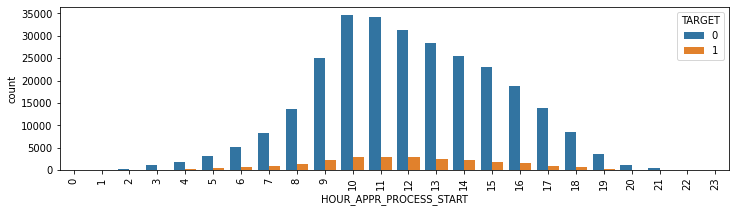

In [100]:
plot_var("HOUR_APPR_PROCESS_START", "Loan Hour", continuous=False)

##### REG_REGION_NOT_LIVE_REGION - Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)

In [101]:
app_train["REG_REGION_NOT_LIVE_REGION"].value_counts()

0    302850
1      4657
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64

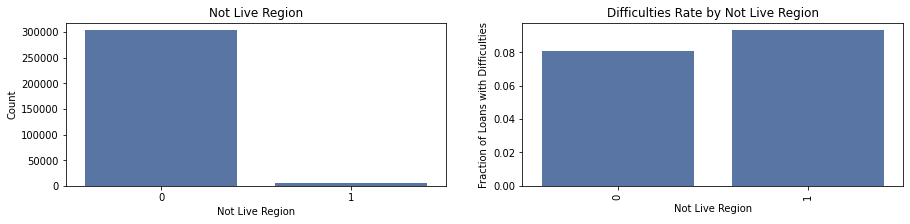

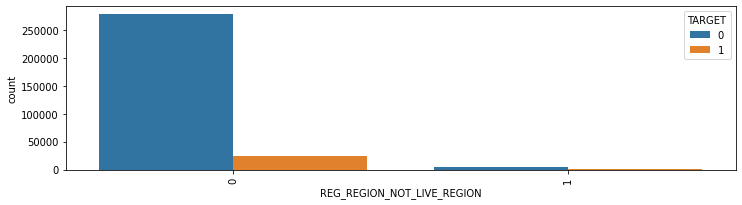

In [102]:
plot_var("REG_REGION_NOT_LIVE_REGION", "Not Live Region", continuous=False)

##### REG_REGION_NOT_WORK_REGION - Flag if client's permanent address does not match work address (1=different, 0=same, at region level)

In [103]:
app_train["REG_REGION_NOT_WORK_REGION"].value_counts()

0    291895
1     15612
Name: REG_REGION_NOT_WORK_REGION, dtype: int64

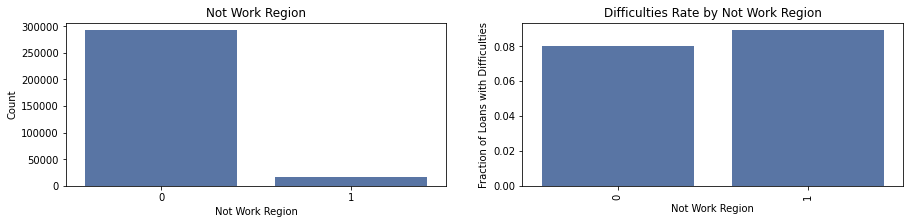

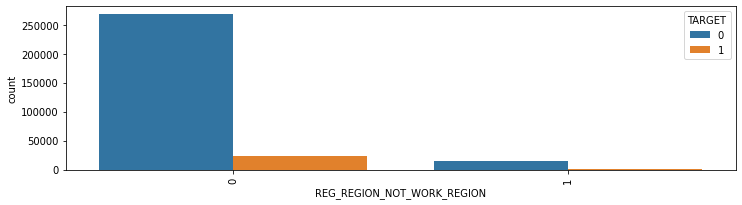

In [104]:
plot_var("REG_REGION_NOT_WORK_REGION", "Not Work Region", continuous=False)

##### LIVE_REGION_NOT_WORK_REGION - Flag if client's contact address does not match work address (1=different, 0=same, at region level)

In [105]:
app_train["LIVE_REGION_NOT_WORK_REGION"].value_counts()

0    295004
1     12503
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64

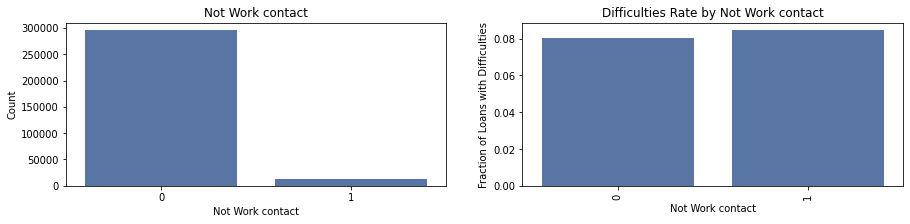

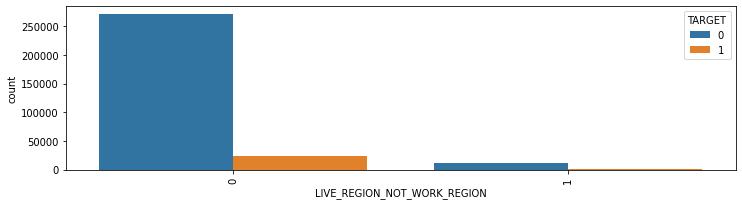

In [106]:
plot_var("LIVE_REGION_NOT_WORK_REGION", "Not Work contact", continuous=False)

In [107]:
app_train[
    [
        "REG_REGION_NOT_LIVE_REGION",
        "REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION",
    ]
].corr()

REG_REGION_NOT_LIVE_REGION  \
REG_REGION_NOT_LIVE_REGION                         1.00   
REG_REGION_NOT_WORK_REGION                         0.45   
LIVE_REGION_NOT_WORK_REGION                        0.09   

                             REG_REGION_NOT_WORK_REGION  \
REG_REGION_NOT_LIVE_REGION                         0.45   
REG_REGION_NOT_WORK_REGION                         1.00   
LIVE_REGION_NOT_WORK_REGION                        0.86   

                             LIVE_REGION_NOT_WORK_REGION  
REG_REGION_NOT_LIVE_REGION                          0.09  
REG_REGION_NOT_WORK_REGION                          0.86  
LIVE_REGION_NOT_WORK_REGION                         1.00

Lets replace 3 of those columns to just 1, we will call it 'ADDRESS_MISMATCH' assign value 1 if any of those 3 columns have 1, otherwise 0.

In [108]:
app_train["ADDRESS_MISMATCH"] = 0
app_test["ADDRESS_MISMATCH"] = 0

In [109]:
app_train.loc[
    app_train[
        [
            "REG_REGION_NOT_LIVE_REGION",
            "REG_REGION_NOT_WORK_REGION",
            "LIVE_REGION_NOT_WORK_REGION",
        ]
    ]
    .ne(0)
    .any(axis=1),
    "ADDRESS_MISMATCH",
] = 1
app_test.loc[
    app_test[
        [
            "REG_REGION_NOT_LIVE_REGION",
            "REG_REGION_NOT_WORK_REGION",
            "LIVE_REGION_NOT_WORK_REGION",
        ]
    ]
    .ne(0)
    .any(axis=1),
    "ADDRESS_MISMATCH",
] = 1

And drop those columns.

In [110]:
app_train.drop(
    [
        "REG_REGION_NOT_LIVE_REGION",
        "REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION",
    ],
    axis=1,
    inplace=True,
)
app_test.drop(
    [
        "REG_REGION_NOT_LIVE_REGION",
        "REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION",
    ],
    axis=1,
    inplace=True,
)

We have 3 same features, but for City level rather then Region, we will drop those.

In [111]:
app_train.drop(
    ["REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"],
    axis=1,
    inplace=True,
)
app_test.drop(
    ["REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"],
    axis=1,
    inplace=True,
)

##### ORGANIZATION_TYPE - Type of organization where client works

In [112]:
app_train["ORGANIZATION_TYPE"].describe()

count                     307507
unique                        58
top       Business Entity Type 3
freq                       67992
Name: ORGANIZATION_TYPE, dtype: object

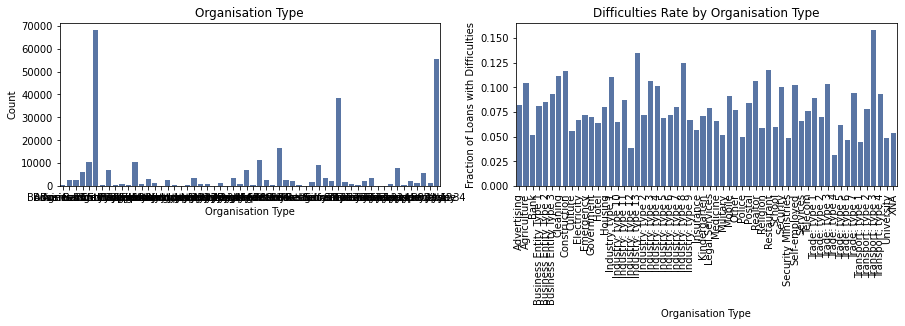

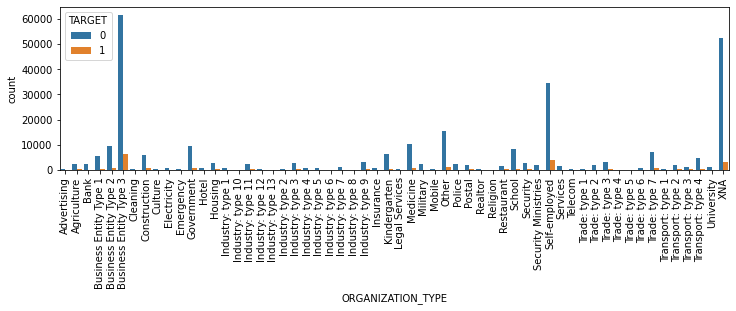

In [113]:
plot_var("ORGANIZATION_TYPE", "Organisation Type", continuous=False)

There is very not significant difference between organisation types and our target, might be dropped later.

##### EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 - Normalized score from external data source,normalized

In [114]:
app_train["EXT_SOURCE_1"].describe()

count   134131.00
mean         0.50
std          0.21
min          0.01
25%          0.33
50%          0.51
75%          0.68
max          0.96
Name: EXT_SOURCE_1, dtype: float64

Some of the external source scores are missing values, lets make a new column, averaging 3 scores to 1, ignoring NaN's

In [115]:
app_train["EXT_SOURCE_AVG"] = np.nanmean(
    app_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
)
app_test["EXT_SOURCE_AVG"] = np.nanmean(
    app_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
)

Fill NaN values with 0, as we can interpret missing score as 0

In [116]:
app_train["EXT_SOURCE_AVG"].fillna(0, inplace=True)
app_test["EXT_SOURCE_AVG"].fillna(0, inplace=True)

Drop ext_source columns

In [117]:
app_train.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], axis=1, inplace=True)
app_test.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], axis=1, inplace=True)

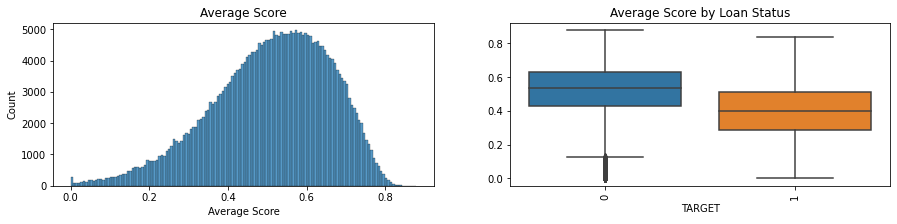

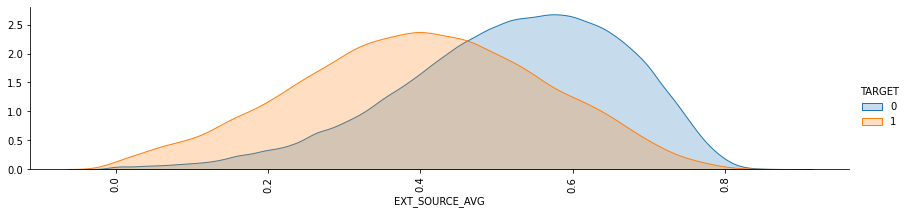

In [118]:
plot_var("EXT_SOURCE_AVG", "Average Score", continuous=True)

We can see that for high scores (>0.5) cases with loan difficulties starts to drop significantly. Useful feature.

##### Building Information - Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor,normalized

Lets just keep one sort of information, AVG and remove MODE/MEDI columns

In [119]:
cols_to_remove = [
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
]

In [120]:
app_train = app_train.drop(labels=cols_to_remove, axis=1)
app_test = app_test.drop(labels=cols_to_remove, axis=1)

We will not go into detailed analysis of building data, lets just keep it and impute missing information during ML modelling.

##### Observation of client's social surroundings with observable DPD (days past due) default

In [121]:
app_train[
    [
        "OBS_30_CNT_SOCIAL_CIRCLE",
        "DEF_30_CNT_SOCIAL_CIRCLE",
        "OBS_60_CNT_SOCIAL_CIRCLE",
        "DEF_60_CNT_SOCIAL_CIRCLE",
    ]
].corr()

OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
OBS_30_CNT_SOCIAL_CIRCLE                      1.00                      0.33   
DEF_30_CNT_SOCIAL_CIRCLE                      0.33                      1.00   
OBS_60_CNT_SOCIAL_CIRCLE                      1.00                      0.33   
DEF_60_CNT_SOCIAL_CIRCLE                      0.25                      0.86   

                          OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  
OBS_30_CNT_SOCIAL_CIRCLE                      1.00                      0.25  
DEF_30_CNT_SOCIAL_CIRCLE                      0.33                      0.86  
OBS_60_CNT_SOCIAL_CIRCLE                      1.00                      0.26  
DEF_60_CNT_SOCIAL_CIRCLE                      0.26                      1.00

Lets only keep those with 60 DPD.

In [122]:
app_train.drop(
    ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE"], axis=1, inplace=True
)
app_test.drop(
    ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE"], axis=1, inplace=True
)

##### OBS_60_CNT_SOCIAL_CIRCLE - How many observation of client's social surroundings with observable 60 DPD (days past due) default

In [123]:
app_train["OBS_60_CNT_SOCIAL_CIRCLE"].describe()

count   306486.00
mean         1.41
std          2.38
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        344.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

There is clearly an outlier '344' which is the only that high value, lets check if it exists in our test data.

In [124]:
app_test["OBS_60_CNT_SOCIAL_CIRCLE"].describe()

count   48715.00
mean        1.44
std         3.58
min         0.00
25%         0.00
50%         0.00
75%         2.00
max       351.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

There is such high value, so we will keep it, for our ML model to learn that case.

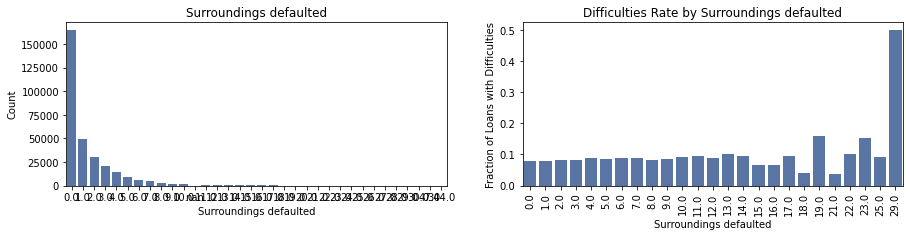

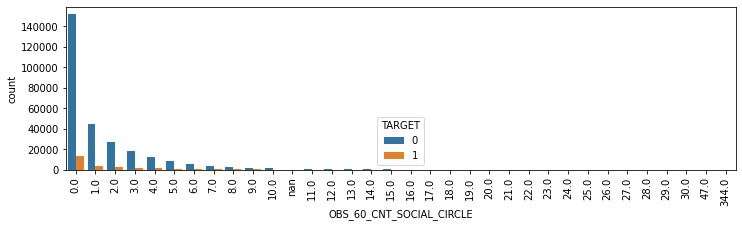

In [125]:
plot_var("OBS_60_CNT_SOCIAL_CIRCLE", "Surroundings defaulted", continuous=False)

##### DEF_60_CNT_SOCIAL_CIRCLE - How many observation of client's social surroundings defaulted on 60 (days past due) DPD

In [126]:
app_train["DEF_60_CNT_SOCIAL_CIRCLE"].describe()

count   306486.00
mean         0.10
std          0.36
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         24.00
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

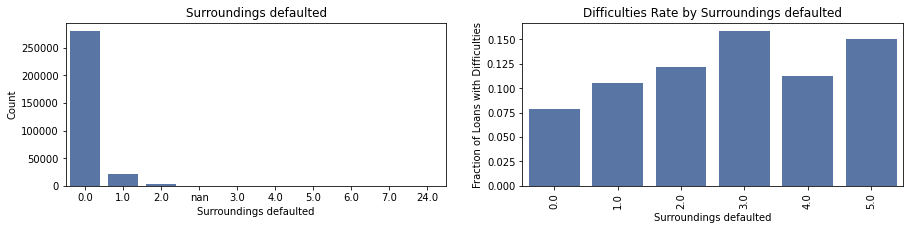

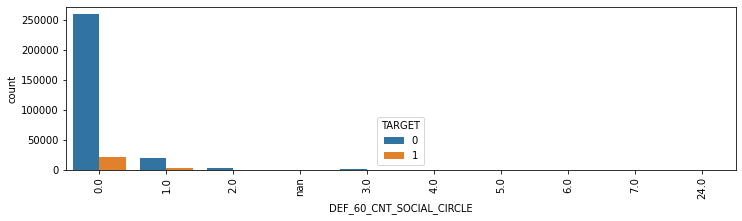

In [127]:
plot_var("DEF_60_CNT_SOCIAL_CIRCLE", "Surroundings defaulted", continuous=False)

##### DAYS_LAST_PHONE_CHANGE - How many days before application did client change phone

In [128]:
app_train["DAYS_LAST_PHONE_CHANGE"].describe()

count   307506.00
mean      -962.86
std        826.81
min      -4292.00
25%      -1570.00
50%       -757.00
75%       -274.00
max          0.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

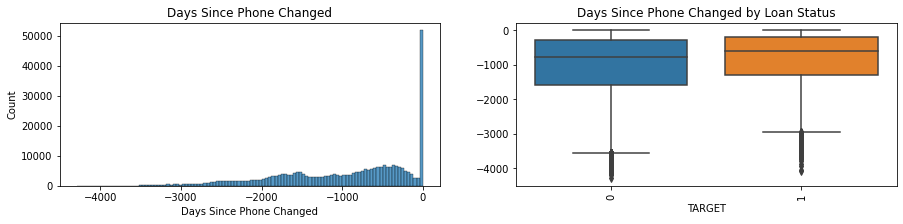

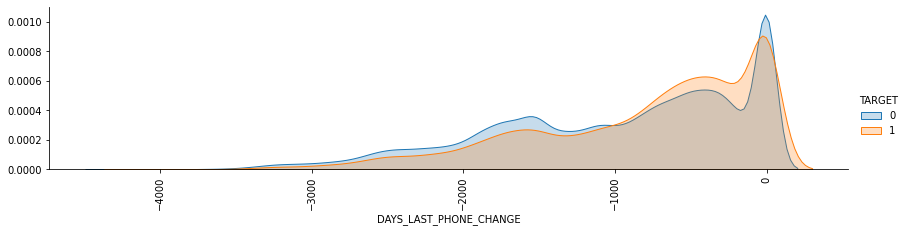

In [129]:
plot_var("DAYS_LAST_PHONE_CHANGE", "Days Since Phone Changed", continuous=True)

##### PROVIDED DOCUMENTS 

In [130]:
docs = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

In [131]:
print(*(f"{doc}: {app_train[{doc}].value_counts()[1]}" for doc in docs), sep="\n")

FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 218340
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_DOCUMENT_9: 1198
FLAG_DOCUMENT_10: 7
FLAG_DOCUMENT_11: 1203
FLAG_DOCUMENT_12: 2
FLAG_DOCUMENT_13: 1084
FLAG_DOCUMENT_14: 903
FLAG_DOCUMENT_15: 372
FLAG_DOCUMENT_16: 3053
FLAG_DOCUMENT_17: 82
FLAG_DOCUMENT_18: 2500
FLAG_DOCUMENT_19: 183
FLAG_DOCUMENT_20: 156
FLAG_DOCUMENT_21: 103


Lets remove those document flags, that has less that 1k positive records.

In [132]:
docs_to_remove = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

In [133]:
app_train.drop(docs_to_remove, axis=1, inplace=True)
app_test.drop(docs_to_remove, axis=1, inplace=True)

##### Number of enquiries to Credit Bureau about the client sometime ago

In [134]:
app_train[
    [
        "AMT_REQ_CREDIT_BUREAU_HOUR",
        "AMT_REQ_CREDIT_BUREAU_DAY",
        "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_MON",
        "AMT_REQ_CREDIT_BUREAU_QRT",
        "AMT_REQ_CREDIT_BUREAU_YEAR",
    ]
].corr()

AMT_REQ_CREDIT_BUREAU_HOUR  \
AMT_REQ_CREDIT_BUREAU_HOUR                        1.00   
AMT_REQ_CREDIT_BUREAU_DAY                         0.23   
AMT_REQ_CREDIT_BUREAU_WEEK                        0.00   
AMT_REQ_CREDIT_BUREAU_MON                        -0.00   
AMT_REQ_CREDIT_BUREAU_QRT                        -0.00   
AMT_REQ_CREDIT_BUREAU_YEAR                       -0.00   

                            AMT_REQ_CREDIT_BUREAU_DAY  \
AMT_REQ_CREDIT_BUREAU_HOUR                       0.23   
AMT_REQ_CREDIT_BUREAU_DAY                        1.00   
AMT_REQ_CREDIT_BUREAU_WEEK                       0.22   
AMT_REQ_CREDIT_BUREAU_MON                       -0.01   
AMT_REQ_CREDIT_BUREAU_QRT                       -0.00   
AMT_REQ_CREDIT_BUREAU_YEAR                      -0.00   

                            AMT_REQ_CREDIT_BUREAU_WEEK  \
AMT_REQ_CREDIT_BUREAU_HOUR                        0.00   
AMT_REQ_CREDIT_BUREAU_DAY                         0.22   
AMT_REQ_CREDIT_BUREAU_WEEK                        1.00   
AMT_REQ_CREDIT_BUREAU_MON                        -0.01   
AMT_REQ_CREDIT_BUREAU_QRT                        -0.02   
AMT_REQ_CREDIT_BUREAU_YEAR                        0.02   

                            AMT_REQ_CREDIT_BUREAU_MON  \
AMT_REQ_CREDIT_BUREAU_HOUR                      -0.00   
AMT_REQ_CREDIT_BUREAU_DAY                       -0.01   
AMT_REQ_CREDIT_BUREAU_WEEK                      -0.01   
AMT_REQ_CREDIT_BUREAU_MON                        1.00   
AMT_REQ_CREDIT_BUREAU_QRT                       -0.01   
AMT_REQ_CREDIT_BUREAU_YEAR                      -0.00   

                            AMT_REQ_CREDIT_BUREAU_QRT  \
AMT_REQ_CREDIT_BUREAU_HOUR                      -0.00   
AMT_REQ_CREDIT_BUREAU_DAY                       -0.00   
AMT_REQ_CREDIT_BUREAU_WEEK                      -0.02   
AMT_REQ_CREDIT_BUREAU_MON                       -0.01   
AMT_REQ_CREDIT_BUREAU_QRT                        1.00   
AMT_REQ_CREDIT_BUREAU_YEAR                       0.08   

                            AMT_REQ_CREDIT_BUREAU_YEAR  
AMT_REQ_CREDIT_BUREAU_HOUR                       -0.00  
AMT_REQ_CREDIT_BUREAU_DAY                        -0.00  
AMT_REQ_CREDIT_BUREAU_WEEK                        0.02  
AMT_REQ_CREDIT_BUREAU_MON                        -0.00  
AMT_REQ_CREDIT_BUREAU_QRT                         0.08  
AMT_REQ_CREDIT_BUREAU_YEAR                        1.00

There is no correlation between those features, lets just look at one of those features, yearly one

In [135]:
app_train["AMT_REQ_CREDIT_BUREAU_YEAR"].describe()

count   265988.00
mean         1.90
std          1.87
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         25.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

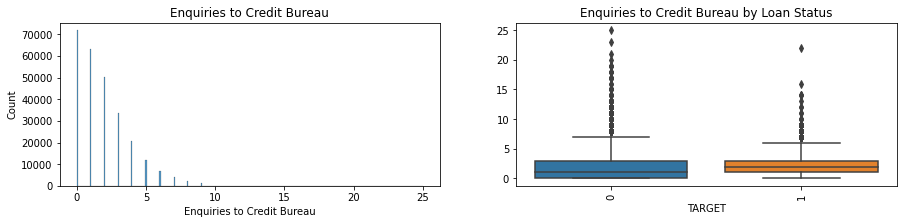

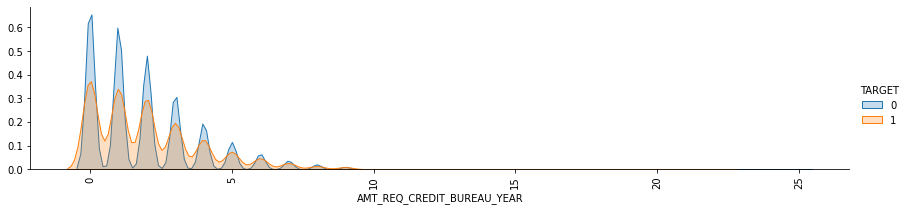

In [136]:
plot_var("AMT_REQ_CREDIT_BUREAU_YEAR", "Enquiries to Credit Bureau", continuous=True)

In [137]:
corr = app_train.corr()
plt.figure(figsize=(36, 36), dpi=480)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm", vmin=-1, vmax=1)

<AxesSubplot:>

- CNT_CHILDREN has a high positive correlation with CNT_FAM_MEMBERS (0.9), it makes sense, those two columns are interconnected, we will get rid of CNT_FAM_MEMBERS
- AMT_CREDIT has a high positive correlation with AMT_ANNUITY and AMT_GOODS_PRICE, lets get rid of latter two
- Interesting negative correlation between REGION_POPULATION and REGION_RATING, which tells us that higher populated regions has lower rating and vice versa. Might be worth to perform statistical significance test.
- Age is somehow positively correlated with client providing work phone, meaning more mature clients tends to provide work phones more often.
- DOCUMENT_6 has a negative correlation with Work phone flag, so this document might be about some kind of unemployment proof
- Nearly all building information bits correlates with each other, that does make sense, and should not drastically effect on our ML model performance

In [138]:
app_train.drop(
    ["CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_GOODS_PRICE"], axis=1, inplace=True
)
app_test.drop(
    ["CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_GOODS_PRICE"], axis=1, inplace=True
)

#### Statistical significance #1.

Is the mean value of 'REGION_RATING' significantly higher for regions with lower population?

H0 - no difference in rating between different region population

Ha - there is difference in rating between different region population

In [139]:
app_train["REGION_POPULATION_RELATIVE"].describe()

count   307507.00
mean         0.02
std          0.01
min          0.00
25%          0.01
50%          0.02
75%          0.03
max          0.07
Name: REGION_POPULATION_RELATIVE, dtype: float64

In [140]:
low_population = app_train[app_train["REGION_POPULATION_RELATIVE"] < 0.02][
    "REGION_RATING_CLIENT"
].sample(n=100000, random_state=1)
high_population = app_train[app_train["REGION_POPULATION_RELATIVE"] > 0.02][
    "REGION_RATING_CLIENT"
].sample(n=100000, random_state=1)

In [141]:
print(
    f"Mean rating for low_population: {low_population.mean()}, std: {low_population.std()}, sample size: {low_population.size}"
)
print(
    f"Mean rating for high_population: {high_population.mean()}, std: {high_population.std()}, sample size: {high_population.size}"
)

Mean rating for low_population: 2.16936, std: 0.42906763032185197, sample size: 100000
Mean rating for high_population: 1.90107, std: 0.5596480922505355, sample size: 100000


In [142]:
(t_stat, p_val, dof) = sm.stats.ttest_ind(low_population, high_population)
print(f"p value: {p_val}, t statistics: {t_stat}")

p value: 0.0, t statistics: 120.3076003618619


Our p value is 0, which is lower than our alpha, thus we can reject the null hypothesis, and as T statistics is positive value, we can confirm that Low Population regions has higher mean rating.

### Modelling (baseline)

#### Metric Definition

Our goal is to predict if the client will have problems with repaying their loan or not. However it is also lose of money to refuse with loan for a client who would actually be able to pay it in full without any issue. We will go with Recall as main metric, as F1 score will be influenced by the major class because of class imbalance.

In [143]:
x = app_train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y = app_train["TARGET"]

In [144]:
for c in x.columns:
    col_type = x[c].dtype
    if col_type == "object" or col_type.name == "category":
        x[c] = x[c].astype("category")

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

In [146]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84805
           1       0.51      0.01      0.01      7448

    accuracy                           0.92     92253
   macro avg       0.72      0.50      0.48     92253
weighted avg       0.89      0.92      0.88     92253



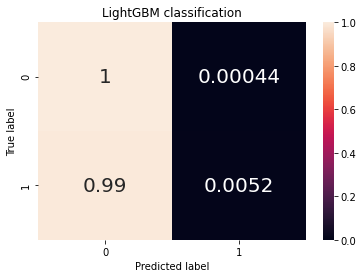

In [147]:
cm = confusion_matrix(y_test, lgb_pred)
plot_confusion_matrix(cm, classes=lgb.classes_, title="LightGBM classification")
print(classification_report(y_test, lgb_pred))

Due to class imbalance, minority class could not be predicted, lets add some parameters

### LGBM Classifier with parameters

In [148]:
lgb = LGBMClassifier(
    num_leaves=15,
    max_depth=-1,
    random_state=314,
    silent=True,
    metric="recall",
    n_jobs=4,
    n_estimators=1000,
    colsample_bytree=0.9,
    subsample=0.9,
    learning_rate=0.1,
    is_unbalance=True,
)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

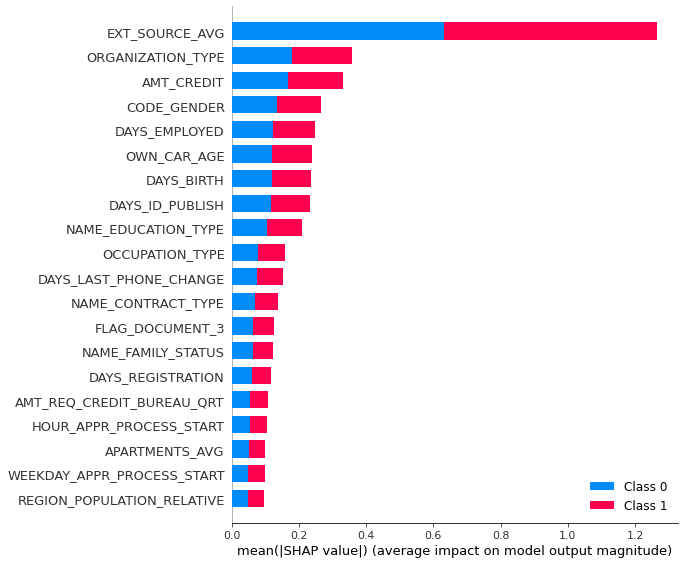

In [149]:
import shap

shap.initjs()
shap_values = shap.TreeExplainer(lgb.booster_).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

We can see that EXT_SOURCE_AVG has highest feature importance, followed by Organization_Type

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     84805
           1       0.17      0.59      0.27      7448

    accuracy                           0.74     92253
   macro avg       0.56      0.67      0.56     92253
weighted avg       0.89      0.74      0.80     92253



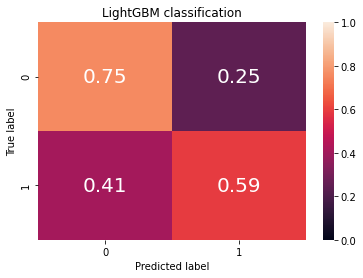

In [150]:
cm = confusion_matrix(y_test, lgb_pred)
plot_confusion_matrix(cm, classes=lgb.classes_, title="LightGBM classification")
print(classification_report(y_test, lgb_pred))

Recall macro avg score here is 0.67, with 0.59 recall for minority class, which is not satisfying, lets try using Logistic Regression for the same data with preprocessing

#### Preprocessing Pipeline

In [151]:
cat_features = []
num_features = []
for c in x.columns:
    col_type = x[c].dtype
    if col_type == "object" or col_type.name == "category":
        cat_features.append(c)
    else:
        num_features.append(c)

In [152]:
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
        ("ordinal", OrdinalEncoder()),
    ]
)
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", num_transformer, num_features),
    ]
)

In [153]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(class_weight="balanced")),
    ]
)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     84805
           1       0.16      0.67      0.25      7448

    accuracy                           0.68     92253
   macro avg       0.56      0.68      0.53     92253
weighted avg       0.89      0.68      0.76     92253



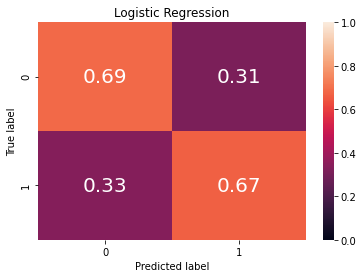

In [154]:
cm = confusion_matrix(y_test, clf_pred)
plot_confusion_matrix(cm, classes=clf.classes_, title="Logistic Regression")
print(classification_report(y_test, clf_pred))

A little better, but still not satisfying, lets try adding more data.

### Analysing additional data (bureau.csv)

In [155]:
len(bureau_df["SK_ID_CURR"].unique())

305811

Less unique clients than in our main dataset

In [156]:
bureau_df.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0              -153.00            -153.00   
1                   0              1075.00                NaN   
2                   0               528.00                NaN   
3                   0                  NaN                NaN   
4                   0              1197.00                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        91323.00   
1                     NaN                   0       225000.00   
2                     NaN                   0       464323.50   
3                     NaN                   0        90000.00   
4                77674.50                   0      2700000.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                 0.00                   NaN                    0.00   
1            171342.00                   NaN                    0.00   
2                  NaN                   NaN                    0.00   
3                  NaN                   NaN                    0.00   
4                  NaN                   NaN                    0.00   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Number of Active/Closed credits migth be useful feature to generate for each client, so lets do that and add to our main dataset

In [157]:
df_active = (
    bureau_df[bureau_df["CREDIT_ACTIVE"] == "Active"]
    .groupby(["SK_ID_CURR", "CREDIT_ACTIVE"])["CREDIT_CURRENCY"]
    .count()
    .reset_index(name="CREDITS_ACTIVE")
)
df_closed = (
    bureau_df[bureau_df["CREDIT_ACTIVE"] == "Closed"]
    .groupby(["SK_ID_CURR", "CREDIT_ACTIVE"])["CREDIT_CURRENCY"]
    .count()
    .reset_index(name="CREDITS_CLOSED")
)

In [158]:
app_train = pd.merge(
    app_train, df_active[["SK_ID_CURR", "CREDITS_ACTIVE"]], on="SK_ID_CURR", how="left"
)
app_train = pd.merge(
    app_train, df_closed[["SK_ID_CURR", "CREDITS_CLOSED"]], on="SK_ID_CURR", how="left"
)

Also, lets add sum of debts that each client has according to the bureau data

In [159]:
df_debt = (
    bureau_df[bureau_df["CREDIT_ACTIVE"] == "Closed"]
    .groupby(["SK_ID_CURR"])["AMT_CREDIT_SUM_DEBT"]
    .sum()
    .reset_index(name="ACTIVE_DEBT_SUM")
)

In [160]:
app_train = pd.merge(
    app_train, df_debt[["SK_ID_CURR", "ACTIVE_DEBT_SUM"]], on="SK_ID_CURR", how="left"
)

In [161]:
# Fill NaNs with 0 for added features
app_train.fillna(
    {"CREDITS_ACTIVE": 0, "CREDITS_CLOSED": 0, "ACTIVE_DEBT_SUM": 0}, inplace=True
)

#### LightGBM again with additional data

In [162]:
x = app_train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y = app_train["TARGET"]

for c in x.columns:
    col_type = x[c].dtype
    if col_type == "object" or col_type.name == "category":
        x[c] = x[c].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

In [163]:
lgb = LGBMClassifier(
    num_leaves=15,
    max_depth=-1,
    random_state=314,
    silent=True,
    metric="recall",
    n_jobs=4,
    n_estimators=1000,
    colsample_bytree=0.9,
    subsample=0.9,
    learning_rate=0.1,
    is_unbalance=True,
)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.76      0.84     84805
           1       0.17      0.59      0.27      7448

    accuracy                           0.74     92253
   macro avg       0.56      0.67      0.56     92253
weighted avg       0.89      0.74      0.80     92253



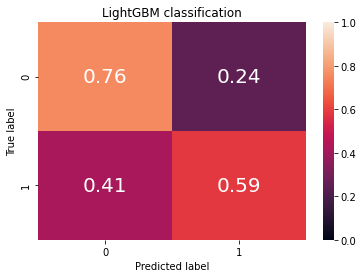

In [164]:
cm = confusion_matrix(y_test, lgb_pred)
plot_confusion_matrix(cm, classes=lgb.classes_, title="LightGBM classification")
print(classification_report(y_test, lgb_pred))

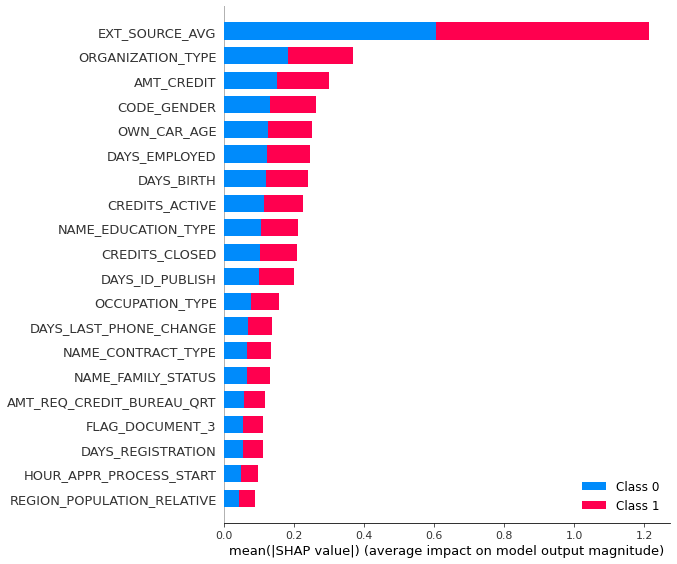

In [165]:
import shap

shap.initjs()
shap_values = shap.TreeExplainer(lgb.booster_).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

No significant changes in feature importance

#### Try XGBoost

In [166]:
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
        ("ordinal", OrdinalEncoder()),
    ]
)
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", num_transformer, num_features),
    ]
)

In [167]:
clf = make_pipeline(
    preprocessor,
    XGBClassifier(
        scale_pos_weight=10, objective="binary:logistic", eval_metric="aucpr"
    ),
)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     84805
           1       0.18      0.57      0.27      7448

    accuracy                           0.75     92253
   macro avg       0.56      0.67      0.56     92253
weighted avg       0.89      0.75      0.80     92253



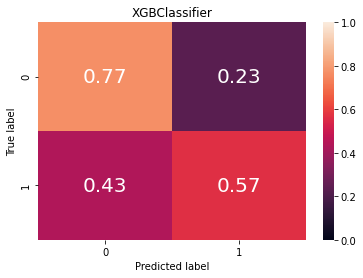

In [168]:
cm = confusion_matrix(y_test, clf_pred)
plot_confusion_matrix(cm, classes=clf.classes_, title="XGBClassifier")
print(classification_report(y_test, clf_pred))

No improvements with XGB. Lets explore more data

### Analysing additional data (previous_app.csv)

In [169]:
previous_app.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans      1730.43         17145.00   
1     2802425      108129         Cash loans     25188.62        607500.00   
2     2523466      122040         Cash loans     15060.74        112500.00   
3     2819243      176158         Cash loans     47041.33        450000.00   
4     1784265      202054         Cash loans     31924.40        337500.00   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0    17145.00              0.00         17145.00                   SATURDAY   
1   679671.00               NaN        607500.00                   THURSDAY   
2   136444.50               NaN        112500.00                    TUESDAY   
3   470790.00               NaN        450000.00                     MONDAY   
4   404055.00               NaN        337500.00                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1               0.00                   0.18   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                      0.87                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0        12.00           middle  POS mobile with interest           365243.00   
1        36.00       low_action          Cash X-Sell: low           365243.00   
2        12.00             high         Cash X-Sell: high           365243.00   
3        12.00           middle       Cash X-Sell: middle           365243.00   
4        24.00             high         Cash Street: high                 NaN   

   D

In [170]:
df = (
    previous_app.groupby(["SK_ID_CURR", "NAME_CONTRACT_STATUS"])["NAME_CONTRACT_TYPE"]
    .count()
    .reset_index(name="count")
    .head(50)
)

In [171]:
prev_status = df.pivot_table(
    "count", "SK_ID_CURR", "NAME_CONTRACT_STATUS"
).reset_index()

In [172]:
prev_status.rename(
    columns={
        "Approved": "PREV_APPROVED",
        "Canceled": "PREV_CANCELED",
        "Refused": "PREV_REFUSED",
    },
    inplace=True,
)

In [173]:
app_train = pd.merge(
    app_train,
    prev_status[["SK_ID_CURR", "PREV_APPROVED", "PREV_CANCELED", "PREV_REFUSED"]],
    on="SK_ID_CURR",
    how="left",
)

In [174]:
# Fill NaNs with 0 for added features
app_train.fillna(
    {"PREV_APPROVED": 0, "PREV_CANCELED": 0, "PREV_REFUSED": 0}, inplace=True
)

### Analysing additional data (POS_CASH_balance.csv)

In [175]:
pos_cash_bal.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31           48.00   
1     1715348      367990             -33           36.00   
2     1784872      397406             -32           12.00   
3     1903291      269225             -35           48.00   
4     2341044      334279             -35           36.00   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                  45.00               Active       0           0  
1                  35.00               Active       0           0  
2                   9.00               Active       0           0  
3                  42.00               Active       0           0  
4                  35.00               Active       0           0

In [176]:
installments_left = (
    pos_cash_bal.groupby("SK_ID_CURR")["CNT_INSTALMENT_FUTURE"]
    .sum()
    .reset_index(name="INSTALLMENTS_LEFT")
)

In [177]:
app_train = pd.merge(app_train, installments_left, on="SK_ID_CURR", how="left")

In [178]:
# Fill NaNs with 0 for added features
app_train["INSTALLMENTS_LEFT"].fillna(0, inplace=True)

### Analysing additional data (credit_card_balance.csv)

In [179]:
credit_card_bal.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6        56.97   
1     2582071      363914              -1     63975.56   
2     1740877      371185              -7     31815.22   
3     1389973      337855              -4    236572.11   
4     1891521      126868              -1    453919.46   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                      0.00                877.50   
1                    45000                   2250.00               2250.00   
2                   450000                      0.00                  0.00   
3                   225000                   2250.00               2250.00   
4                   450000                      0.00              11547.00   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                        0.00                    877.50   
1                        0.00                      0.00   
2                        0.00                      0.00   
3                        0.00                      0.00   
4                        0.00                  11547.00   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                  1700.33              1800.00                    1800.00   
1                  2250.00              2250.00                    2250.00   
2                  2250.00              2250.00                    2250.00   
3                 11795.76             11925.00                   11925.00   
4                 22924.89             27000.00                   27000.00   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                      0.00           0.00                  0.00   
1                  60175.08       64875.56              64875.56   
2                  26926.42       31460.08              31460.08   
3                 224949.29      233048.97             233048.97   
4                 443044.40      453919.46             453919.46   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                      0.00                     1                        0.00   
1                      1.00                     1                        0.00   
2                      0.00                     0                        0.00   
3                      1.00                     1                        0.00   
4                      0.00                     1                        0.00   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                      1.00                      35.00               Active   
1                      0.00                      69.00               Active   
2                      0.00                      30.00               Active   
3                      0.00                      10.00               Active   
4                      1.00                     101.00               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [180]:
credit_card_df = credit_card_bal[
    [
        "SK_ID_CURR",
        "AMT_BALANCE",
        "AMT_CREDIT_LIMIT_ACTUAL",
        "AMT_DRAWINGS_ATM_CURRENT",
        "AMT_DRAWINGS_CURRENT",
        "AMT_DRAWINGS_OTHER_CURRENT",
        "AMT_DRAWINGS_POS_CURRENT",
        "AMT_INST_MIN_REGULARITY",
        "AMT_PAYMENT_CURRENT",
        "AMT_PAYMENT_TOTAL_CURRENT",
        "AMT_RECEIVABLE_PRINCIPAL",
        "AMT_RECIVABLE",
        "AMT_TOTAL_RECEIVABLE",
    ]
]

Lets group credit_card data by clients ID, average historical values, and add that to our dataset

In [181]:
credit_card_df = (
    credit_card_df.groupby("SK_ID_CURR").mean().reset_index().fillna(0, axis=1)
)

In [182]:
app_train = pd.merge(app_train, credit_card_df, on="SK_ID_CURR", how="left")

### LightGBM again with parameter tuning

In [183]:
x = app_train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y = app_train["TARGET"]

In [184]:
for c in x.columns:
    col_type = x[c].dtype
    if col_type == "object" or col_type.name == "category":
        x[c] = x[c].astype("category")

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

In [186]:
param_grid = {
    "boosting_type": ["gbdt"],
    "num_leaves": [32],
    "learning_rate": [0.05370330766667166],
    "subsample_for_bin": list(range(150000, 300000, 20000)),
    "min_child_samples": list(range(300, 500, 20)),
    "reg_alpha": list(np.linspace(0, 1)),
    "reg_lambda": list(np.linspace(0, 1)),
    "colsample_bytree": list(np.linspace(0.6, 1, 10)),
    "subsample": list(np.linspace(0.5, 1, 100)),
    "is_unbalance": [True],
}

In [188]:
lgb = LGBMClassifier()
lgbmodel = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_grid,
    n_iter=100,
    verbose=1,
    n_jobs=-1,
    scoring="recall",
    cv=5,
)
lgbmodel.fit(X_train, y_train)
lgb_pred = lgbmodel.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [189]:
lgb_train_pred = lgbmodel.predict(X_train)
recall_score(y_train, lgb_train_pred)

0.7310813143810785

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84805
           1       0.17      0.68      0.27      7448

    accuracy                           0.70     92253
   macro avg       0.56      0.69      0.54     92253
weighted avg       0.90      0.70      0.77     92253



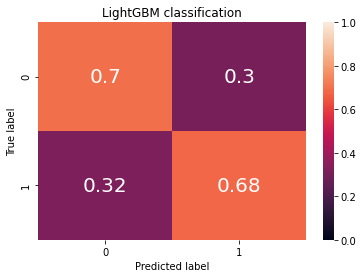

In [190]:
cm = confusion_matrix(y_test, lgb_pred)
plot_confusion_matrix(cm, classes=lgbmodel.classes_, title="LightGBM classification")
print(classification_report(y_test, lgb_pred))

A little improvement here

##### Threshold moving

Depending on business case, we could move our Threshold, which would import our prediction of one class losing the accuracy for other class. 


If it is crucial to predict those clients with risk of not repaying loan in time, losing some potential clients, we can tweak the threshold the following way:

              precision    recall  f1-score   support

           0       0.97      0.55      0.70     84805
           1       0.14      0.80      0.23      7448

    accuracy                           0.57     92253
   macro avg       0.55      0.68      0.47     92253
weighted avg       0.90      0.57      0.66     92253



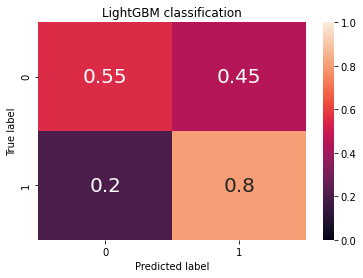

In [191]:
lgb_pred = (lgbmodel.predict_proba(X_test)[:, 1] > 0.4).astype("float")


cm = confusion_matrix(y_test, lgb_pred)
plot_confusion_matrix(cm, classes=lgbmodel.classes_, title="LightGBM classification")
print(classification_report(y_test, lgb_pred))

We have achieved 80% recall for those risky clients, which might be a good module to go with

In [192]:
cat_features = []
num_features = []
for c in x.columns:
    col_type = x[c].dtype
    if col_type == "object" or col_type.name == "category":
        cat_features.append(c)
    else:
        num_features.append(c)

In [193]:
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
        ("ordinal", OrdinalEncoder()),
    ]
)
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", num_transformer, num_features),
    ]
)

Lets try over sampling methods to avoid data imbalance

In [194]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=101)

clf = make_pipeline(preprocessor, adasyn, LogisticRegression())
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     84805
           1       0.16      0.66      0.25      7448

    accuracy                           0.69     92253
   macro avg       0.56      0.67      0.53     92253
weighted avg       0.89      0.69      0.76     92253



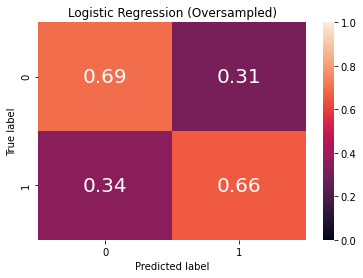

In [195]:
cm = confusion_matrix(y_test, clf_pred)
plot_confusion_matrix(
    cm, classes=clf.classes_, title="Logistic Regression (Oversampled)"
)
print(classification_report(y_test, clf_pred))

Not good enough

#### Try CatBooster Classifier

In [197]:
cat = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", CatBoostClassifier(scale_pos_weight=9)),
    ]
)

Tune parameters

In [199]:
hyperparameter_grid = {
    "classifier__iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "classifier__depth": list(range(1, 10)),
    "classifier__learning_rate": [0.01, 0.02, 0.03, 0.04],
    "classifier__min_data_in_leaf": list(range(300, 500, 20)),
}


random_cv = RandomizedSearchCV(
    estimator=cat,
    param_distributions=hyperparameter_grid,
    cv=5,
    n_iter=100,
    scoring="recall",
    n_jobs=-1,
    verbose=5,
    return_train_score=True,
    random_state=42,
)


random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 0.6884770	total: 26.1ms	remaining: 1.02s
1:	learn: 0.6839939	total: 40.5ms	remaining: 769ms
2:	learn: 0.6797278	total: 55.2ms	remaining: 680ms
3:	learn: 0.6757401	total: 70.9ms	remaining: 638ms
4:	learn: 0.6720616	total: 85.3ms	remaining: 597ms
5:	learn: 0.6685879	total: 98ms	remaining: 555ms
6:	learn: 0.6652586	total: 111ms	remaining: 524ms
7:	learn: 0.6622908	total: 124ms	remaining: 495ms
8:	learn: 0.6592562	total: 137ms	remaining: 471ms
9:	learn: 0.6565217	total: 150ms	remaining: 450ms
10:	learn: 0.6538648	total: 163ms	remaining: 429ms
11:	learn: 0.6514108	total: 177ms	remaining: 413ms
12:	learn: 0.6491599	total: 190ms	remaining: 394ms
13:	learn: 0.6470086	total: 203ms	remaining: 378ms
14:	learn: 0.6450310	total: 217ms	remaining: 362ms
15:	learn: 0.6429407	total: 233ms	remaining: 349ms
16:	learn: 0.6410369	total: 247ms	remaining: 334ms
17:	learn: 0.6392666	total: 260ms	remaining: 318ms
18:	learn: 0.6376412	tota

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ordinal',
                                                                                                OrdinalEncoder())]),
                                                                               ['NAME_CONTRACT_TYPE',
                                                                                'CODE_GENDER',
                                                                                'FLAG_OWN_CAR',
                                                                 

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     84805
           1       0.17      0.58      0.26      7448

    accuracy                           0.74     92253
   macro avg       0.56      0.66      0.55     92253
weighted avg       0.89      0.74      0.79     92253



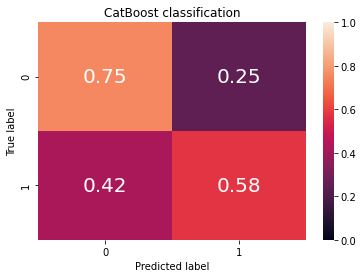

In [200]:
random_pred = random_cv.predict(X_test)

cm = confusion_matrix(y_test, random_pred)
plot_confusion_matrix(cm, classes=random_cv.classes_, title="CatBoost classification")
print(classification_report(y_test, random_pred))

CatBooster Classifier seems to be comparable with LightGBM however it requires preprocessing, when LightGBM can handle NaN values and categorical features on its own, giving the same results. We will go with LightGBM Classifier as our final model

In [201]:
pickle_out = open("lgbmodel.pkl", "wb")
pickle.dump(lgbmodel, pickle_out)
pickle_out.close()

### Conclusion

We could acieve a decent model, that can be tweaked to a business needs by moving the threshold. To improve this model, a discussion with domain experts would help, and doing a more extensive Feature Engineering after.